Loading data...
Missing values in features: 51735
Missing values in target: 0
Final dataset shape: (41184, 41)
Target statistics:
  Mean: -0.165
  Std: 1.019
  Min: -2.412
  Max: 2.412
Preparing data for training...
Model architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5376      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropou

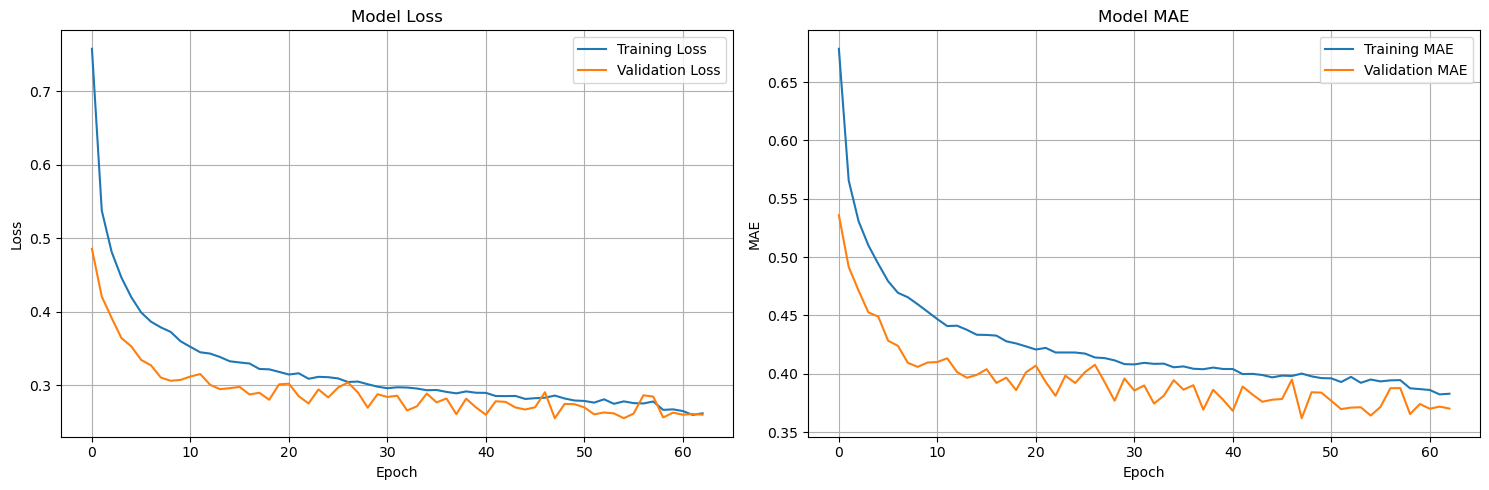

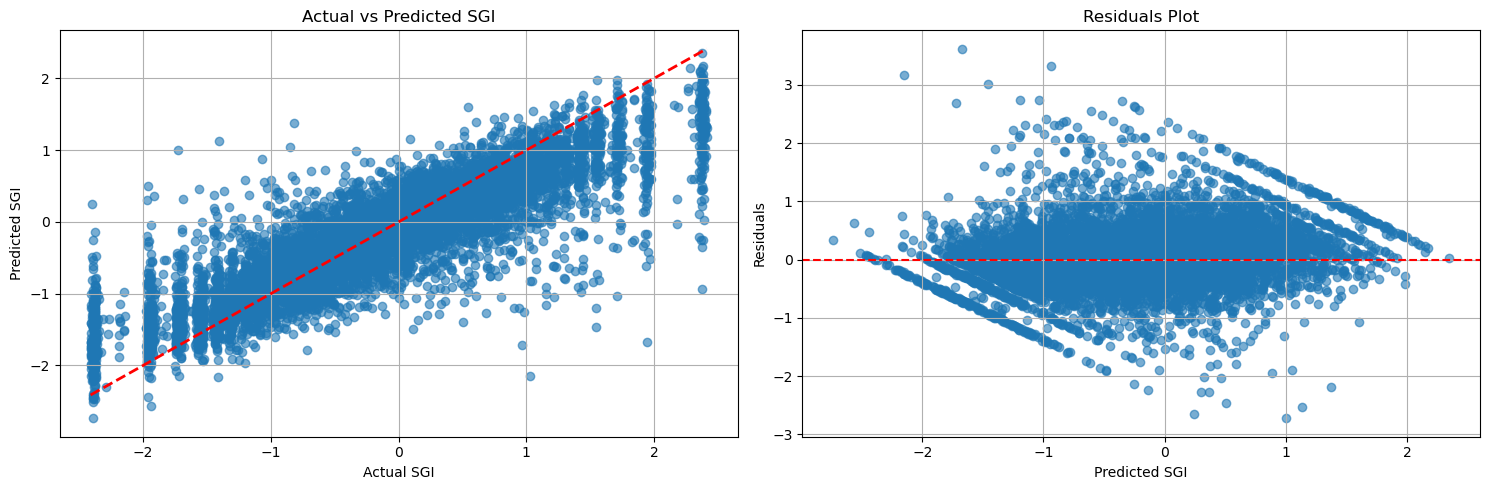

Feature importance analysis would require additional implementation.
Consider using SHAP values or permutation importance for detailed analysis.

Features used in the model (41):
 1. main_landuse_cropland_rainfed
 2. sgi_label_lag_3M
 3. snow_depth_monthly
 4. month_num_10
 5. sgi_label_lag_12M
 6. month_num_5
 7. month_num_9
 8. sgi_seasonal_lag_1M
 9. topographic_slope_degrees
10. withdrawal_industrial_monthly
11. withdrawal_domestic_monthly
12. sgi_resid_lag_12M
13. ndvi_monthly
14. sgi_seasonal_lag_12M
15. precipitation_monthly
16. sgi_label_lag_1M
17. evapotranspiration_monthly
18. sgi_resid_lag_1M
19. month_num_12
20. main_landuse_forests_and_natural_vegetation
21. sgi_resid_lag_3M
22. sgi_label_lag_6M
23. sgi_trend_lag_3M
24. air_temperature_monthly
25. sgi_trend_lag_6M
26. ground_elevation_m_asl
27. month_num_7
28. sgi_seasonal_lag_6M
29. month_num_8
30. month_num_4
31. month_num_6
32. sgi_resid_lag_6M
33. lai_high_veg_monthly
34. sgi_seasonal_lag_3M
35. month_num_2
36. month_n

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class SGIPredictor:
    def __init__(self):
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.model = None
        self.feature_names = None
        
    def load_and_preprocess_data(self, file_path):
        """Load and preprocess the training data"""
        print("Loading data...")
        df = pd.read_csv(file_path)
        
        # Convert date column to datetime
        df['date'] = pd.to_datetime(df['date'])
        
        # Remove date column for modeling (keep for analysis if needed)
        df_model = df.drop('date', axis=1)
        
        # Separate features and target
        target_col = 'sgi_target_label'
        feature_cols = [col for col in df_model.columns if col != target_col]
        
        X = df_model[feature_cols]
        y = df_model[target_col]
        
        # Handle missing values
        print(f"Missing values in features: {X.isnull().sum().sum()}")
        print(f"Missing values in target: {y.isnull().sum()}")
        
        # Remove rows with missing target values
        mask = ~y.isnull()
        X = X[mask]
        y = y[mask]
        
        # Fill missing feature values with median
        X = X.fillna(X.median())
        
        self.feature_names = feature_cols
        
        print(f"Final dataset shape: {X.shape}")
        print(f"Target statistics:")
        print(f"  Mean: {y.mean():.3f}")
        print(f"  Std: {y.std():.3f}")
        print(f"  Min: {y.min():.3f}")
        print(f"  Max: {y.max():.3f}")
        
        return X, y
    
    def create_model(self, input_dim):
        """Create the neural network architecture"""
        model = keras.Sequential([
            # Input layer with dropout for regularization
            layers.Dense(128, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.3),
            layers.BatchNormalization(),
            
            # Hidden layers with decreasing size
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            
            layers.Dense(16, activation='relu'),
            layers.Dropout(0.1),
            
            # Output layer
            layers.Dense(1, activation='linear')
        ])
        
        # Compile with Adam optimizer and custom learning rate
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def train(self, X, y, validation_split=0.2, epochs=100, batch_size=32):
        """Train the neural network"""
        print("Preparing data for training...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=None
        )
        
        # Scale features and target
        X_train_scaled = self.scaler_X.fit_transform(X_train)
        X_test_scaled = self.scaler_X.transform(X_test)
        
        y_train_scaled = self.scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        y_test_scaled = self.scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
        
        # Create model
        self.model = self.create_model(X_train_scaled.shape[1])
        
        print("Model architecture:")
        self.model.summary()
        
        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )
        
        # Train model
        print("Training model...")
        history = self.model.fit(
            X_train_scaled, y_train_scaled,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Evaluate on test set
        print("\nEvaluating on test set...")
        y_pred_scaled = self.model.predict(X_test_scaled)
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"\nTest Set Performance:")
        print(f"  MSE: {mse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R²: {r2:.4f}")
        print(f"  RMSE: {np.sqrt(mse):.4f}")
        
        # Store test results for plotting
        self.test_results = {
            'y_true': y_test,
            'y_pred': y_pred,
            'history': history
        }
        
        return history
    
    def plot_training_history(self):
        """Plot training history"""
        if not hasattr(self, 'test_results'):
            print("No training history available. Train the model first.")
            return
            
        history = self.test_results['history']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss plot
        ax1.plot(history.history['loss'], label='Training Loss')
        ax1.plot(history.history['val_loss'], label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # MAE plot
        ax2.plot(history.history['mae'], label='Training MAE')
        ax2.plot(history.history['val_mae'], label='Validation MAE')
        ax2.set_title('Model MAE')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_predictions(self):
        """Plot actual vs predicted values"""
        if not hasattr(self, 'test_results'):
            print("No test results available. Train the model first.")
            return
            
        y_true = self.test_results['y_true']
        y_pred = self.test_results['y_pred']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Scatter plot
        ax1.scatter(y_true, y_pred, alpha=0.6)
        ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        ax1.set_xlabel('Actual SGI')
        ax1.set_ylabel('Predicted SGI')
        ax1.set_title('Actual vs Predicted SGI')
        ax1.grid(True)
        
        # Residuals plot
        residuals = y_true - y_pred
        ax2.scatter(y_pred, residuals, alpha=0.6)
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_xlabel('Predicted SGI')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residuals Plot')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def get_feature_importance(self):
        """Get feature importance using permutation importance"""
        if self.model is None:
            print("Model not trained yet.")
            return None
            
        # This is a simplified version - for more accurate feature importance,
        # you might want to use libraries like SHAP or implement permutation importance
        print("Feature importance analysis would require additional implementation.")
        print("Consider using SHAP values or permutation importance for detailed analysis.")
        
        return self.feature_names
    
    def predict(self, X_new):
        """Make predictions on new data"""
        if self.model is None:
            raise ValueError("Model not trained yet.")
            
        X_new_scaled = self.scaler_X.transform(X_new)
        y_pred_scaled = self.model.predict(X_new_scaled)
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        
        return y_pred
    
    def save_model(self, filepath):
        """Save the trained model and scalers"""
        if self.model is None:
            raise ValueError("Model not trained yet.")
            
        # Save model
        self.model.save(f"{filepath}_model.h5")
        
        # Save scalers
        import joblib
        joblib.dump(self.scaler_X, f"{filepath}_scaler_X.pkl")
        joblib.dump(self.scaler_y, f"{filepath}_scaler_y.pkl")
        
        print(f"Model saved to {filepath}_model.h5")
        print(f"Scalers saved to {filepath}_scaler_X.pkl and {filepath}_scaler_y.pkl")

# Usage example
def main():
    # Initialize predictor
    predictor = SGIPredictor()
    
    # Load and preprocess data
    X, y = predictor.load_and_preprocess_data('../train_data.csv.csv')
    
    # Train the model
    history = predictor.train(X, y, epochs=150, batch_size=64)
    
    # Plot results
    predictor.plot_training_history()
    predictor.plot_predictions()
    
    # Get feature names (for importance analysis)
    features = predictor.get_feature_importance()
    print(f"\nFeatures used in the model ({len(features)}):")
    for i, feature in enumerate(features, 1):
        print(f"{i:2d}. {feature}")
    
    # Save the model
    predictor.save_model("sgi_predictor")
    
    return predictor

if __name__ == "__main__":
    predictor = main()

TensorFlow version: 2.10.0
Loading temporal data...
Train data shape: (129036, 43)
Test data shape: (41184, 43)
Train data: up to 2007-12-01 00:00:00
Test data: from 2008-01-01 00:00:00
✓ Clean temporal split confirmed
Common features: 41
Train - Missing values in features: 211055
Train - Missing values in target: 0
Test - Missing values in features: 51735
Test - Missing values in target: 0
Features after variance filtering: 41
Final train shape: (129036, 41)
Final test shape: (41184, 41)

Target statistics:
Train - Mean: 0.063, Std: 0.977
Test - Mean: -0.165, Std: 1.019

Training final model...
Using parameters:
  Architecture: 128-64-32
  Dropout: 0.3, LR: 0.001
Final split: 109680 train, 19356 val, 41184 test
Model architecture:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 128)               5376      
                                      

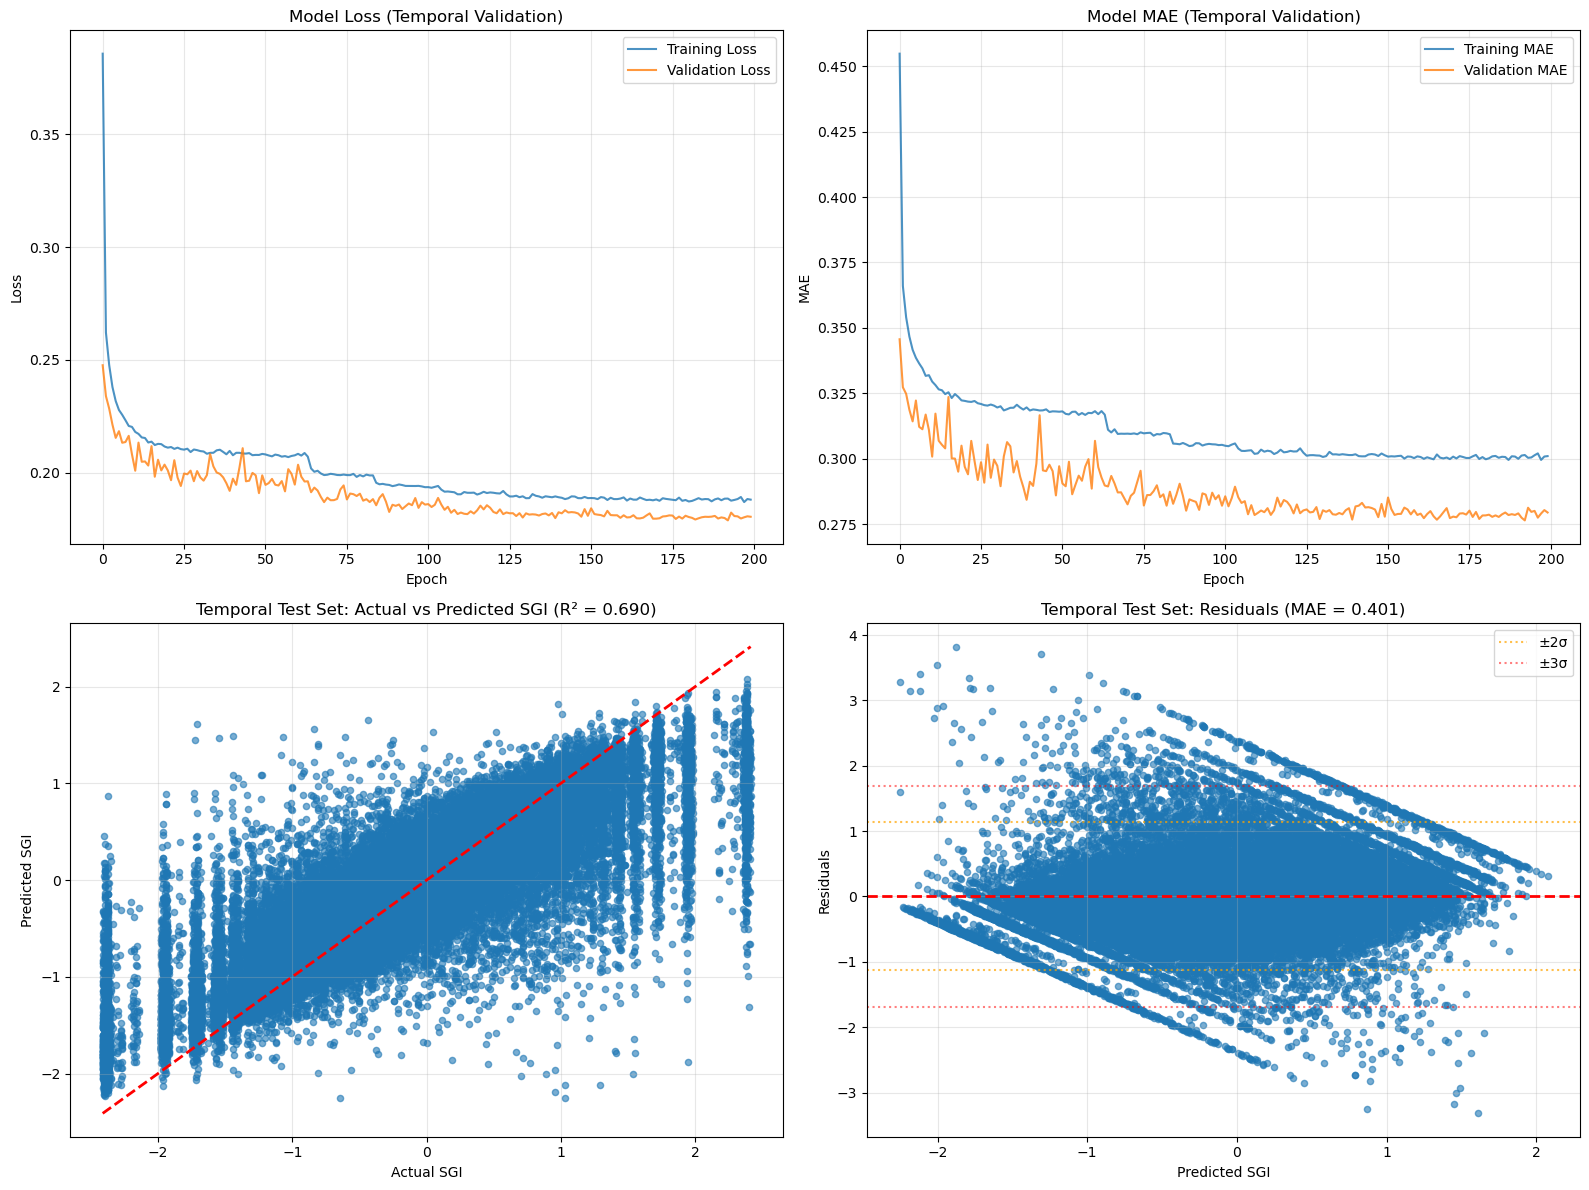

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

class TemporalSGIPredictor:
    def __init__(self):
        self.scaler_X = None
        self.scaler_y = None
        self.model = None
        self.feature_names = None
        self.best_params = None
        
    def load_temporal_data(self, train_path, test_path):
        """Load temporally split train and test data"""
        print("Loading temporal data...")
        
        # Load both datasets
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        
        print(f"Train data shape: {train_df.shape}")
        print(f"Test data shape: {test_df.shape}")
        
        # Convert dates
        train_df['date'] = pd.to_datetime(train_df['date'])
        test_df['date'] = pd.to_datetime(test_df['date'])
        
        # Verify temporal split
        train_max_date = train_df['date'].max()
        test_min_date = test_df['date'].min()
        print(f"Train data: up to {train_max_date}")
        print(f"Test data: from {test_min_date}")
        
        if train_max_date >= test_min_date:
            print("WARNING: Temporal overlap detected!")
        else:
            print("✓ Clean temporal split confirmed")
        
        # Remove date column for modeling
        train_model = train_df.drop('date', axis=1)
        test_model = test_df.drop('date', axis=1)
        
        # Separate features and target
        target_col = 'sgi_target_label'
        feature_cols = [col for col in train_model.columns if col != target_col]
        
        # Ensure both datasets have same columns
        common_features = list(set(feature_cols) & set(test_model.columns))
        if target_col not in test_model.columns:
            raise ValueError(f"Target column '{target_col}' not found in test data")
        
        print(f"Common features: {len(common_features)}")
        
        # Extract features and targets
        X_train = train_model[common_features]
        y_train = train_model[target_col]
        X_test = test_model[common_features]
        y_test = test_model[target_col]
        
        # Handle missing values
        print(f"Train - Missing values in features: {X_train.isnull().sum().sum()}")
        print(f"Train - Missing values in target: {y_train.isnull().sum()}")
        print(f"Test - Missing values in features: {X_test.isnull().sum().sum()}")
        print(f"Test - Missing values in target: {y_test.isnull().sum()}")
        
        # Remove rows with missing target values
        train_mask = ~y_train.isnull()
        test_mask = ~y_test.isnull()
        
        X_train = X_train[train_mask]
        y_train = y_train[train_mask]
        X_test = X_test[test_mask]
        y_test = y_test[test_mask]
        
        # Fill missing feature values with training data statistics
        train_medians = X_train.median()
        X_train = X_train.fillna(train_medians)
        X_test = X_test.fillna(train_medians)  # Use train medians for test data
        
        # Remove features with very low variance (based on training data only)
        selector = VarianceThreshold(threshold=0.01)
        X_train_selected = selector.fit_transform(X_train)
        X_test_selected = selector.transform(X_test)
        
        selected_features = np.array(common_features)[selector.get_support()]
        
        X_train = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
        X_test = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)
        
        self.feature_names = list(selected_features)
        
        print(f"Features after variance filtering: {len(selected_features)}")
        print(f"Final train shape: {X_train.shape}")
        print(f"Final test shape: {X_test.shape}")
        
        # Print target statistics
        print(f"\nTarget statistics:")
        print(f"Train - Mean: {y_train.mean():.3f}, Std: {y_train.std():.3f}")
        print(f"Test - Mean: {y_test.mean():.3f}, Std: {y_test.std():.3f}")
        
        return X_train, y_train, X_test, y_test
    
    def get_optimizer(self, optimizer_name, learning_rate, l2_reg=1e-4):
        """Get optimizer with version compatibility"""
        if optimizer_name == 'adamw':
            try:
                return keras.optimizers.AdamW(
                    learning_rate=learning_rate,
                    weight_decay=l2_reg
                )
            except AttributeError:
                print("AdamW not available, using Adam")
                return keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            return keras.optimizers.Adam(learning_rate=learning_rate)
    
    def get_activation(self, activation_name):
        """Get activation function with version compatibility"""
        if activation_name == 'swish':
            try:
                return keras.activations.swish
            except AttributeError:
                return 'relu'
        elif activation_name == 'elu':
            return 'elu'
        else:
            return 'relu'
    
    def get_loss_function(self, loss_name):
        """Get loss function with version compatibility"""
        if loss_name == 'huber':
            try:
                return keras.losses.Huber()
            except AttributeError:
                return 'mse'
        else:
            return 'mse'
    
    def create_model(self, params, input_dim):
        """Create model with given parameters"""
        model = keras.Sequential()
        
        activation = self.get_activation(params['activation'])
        
        # First layer
        model.add(layers.Dense(
            params['n_units_1'], 
            activation=activation,
            input_shape=(input_dim,),
            kernel_regularizer=keras.regularizers.l2(params['l2_reg'])
        ))
        model.add(layers.Dropout(params['dropout_rate']))
        if params['batch_norm']:
            model.add(layers.BatchNormalization())
        
        # Second layer
        model.add(layers.Dense(
            params['n_units_2'], 
            activation=activation,
            kernel_regularizer=keras.regularizers.l2(params['l2_reg'])
        ))
        model.add(layers.Dropout(params['dropout_rate'] * 0.8))
        if params['batch_norm']:
            model.add(layers.BatchNormalization())
        
        # Third layer
        model.add(layers.Dense(
            params['n_units_3'], 
            activation=activation,
            kernel_regularizer=keras.regularizers.l2(params['l2_reg'])
        ))
        model.add(layers.Dropout(params['dropout_rate'] * 0.6))
        
        # Output layer
        model.add(layers.Dense(1, activation='linear'))
        
        # Get optimizer and loss
        optimizer = self.get_optimizer(params['optimizer'], params['learning_rate'], params['l2_reg'])
        loss_fn = self.get_loss_function(params['loss'])
        
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['mae']
        )
        
        return model
    
    def temporal_validation_search(self, X_train, y_train):
        """Hyperparameter search using temporal validation"""
        print("Starting temporal hyperparameter search...")
        
        # Create temporal validation split (use last 20% of training data as validation)
        split_idx = int(len(X_train) * 0.8)
        X_train_split = X_train.iloc[:split_idx]
        X_val = X_train.iloc[split_idx:]
        y_train_split = y_train.iloc[:split_idx]
        y_val = y_train.iloc[split_idx:]
        
        print(f"Temporal split: {len(X_train_split)} train, {len(X_val)} validation")
        
        # Define parameter combinations
        param_combinations = [
            # Configuration 1: Baseline improved
            {
                'n_units_1': 128, 'n_units_2': 64, 'n_units_3': 32,
                'dropout_rate': 0.3, 'learning_rate': 0.001,
                'batch_norm': True, 'activation': 'elu',
                'optimizer': 'adam', 'l2_reg': 1e-4,
                'loss': 'mse', 'batch_size': 64
            },
            # Configuration 2: Larger network
            {
                'n_units_1': 256, 'n_units_2': 128, 'n_units_3': 64,
                'dropout_rate': 0.4, 'learning_rate': 0.0005,
                'batch_norm': True, 'activation': 'elu',
                'optimizer': 'adam', 'l2_reg': 1e-4,
                'loss': 'mse', 'batch_size': 64
            },
            # Configuration 3: Less regularization
            {
                'n_units_1': 128, 'n_units_2': 64, 'n_units_3': 32,
                'dropout_rate': 0.2, 'learning_rate': 0.001,
                'batch_norm': True, 'activation': 'relu',
                'optimizer': 'adam', 'l2_reg': 1e-5,
                'loss': 'mse', 'batch_size': 32
            },
            # Configuration 4: More regularization
            {
                'n_units_1': 96, 'n_units_2': 48, 'n_units_3': 24,
                'dropout_rate': 0.4, 'learning_rate': 0.0008,
                'batch_norm': True, 'activation': 'elu',
                'optimizer': 'adam', 'l2_reg': 1e-3,
                'loss': 'mse', 'batch_size': 128
            },
            # Configuration 5: Different approach
            {
                'n_units_1': 160, 'n_units_2': 80, 'n_units_3': 40,
                'dropout_rate': 0.35, 'learning_rate': 0.0012,
                'batch_norm': False, 'activation': 'relu',
                'optimizer': 'adam', 'l2_reg': 2e-4,
                'loss': 'mse', 'batch_size': 64
            }
        ]
        
        best_score = float('inf')
        best_params = None
        results = []
        
        # Scale data for validation
        scaler_X = RobustScaler()
        scaler_y = RobustScaler()
        
        X_train_scaled = scaler_X.fit_transform(X_train_split)
        X_val_scaled = scaler_X.transform(X_val)
        
        y_train_scaled = scaler_y.fit_transform(y_train_split.values.reshape(-1, 1)).flatten()
        y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
        
        for i, params in enumerate(param_combinations):
            print(f"\nTesting configuration {i+1}/{len(param_combinations)}")
            print(f"Architecture: {params['n_units_1']}-{params['n_units_2']}-{params['n_units_3']}")
            print(f"Dropout: {params['dropout_rate']}, LR: {params['learning_rate']}")
            
            try:
                model = self.create_model(params, X_train_scaled.shape[1])
                
                early_stopping = keras.callbacks.EarlyStopping(
                    monitor='val_loss', patience=15, restore_best_weights=True, verbose=0
                )
                
                history = model.fit(
                    X_train_scaled, y_train_scaled,
                    validation_data=(X_val_scaled, y_val_scaled),
                    epochs=80,
                    batch_size=params['batch_size'],
                    callbacks=[early_stopping],
                    verbose=0
                )
                
                best_val_loss = min(history.history['val_loss'])
                
                results.append({
                    'config': i+1,
                    'params': params,
                    'val_loss': best_val_loss
                })
                
                print(f"Validation loss: {best_val_loss:.4f}")
                
                if best_val_loss < best_score:
                    best_score = best_val_loss
                    best_params = params
                    print("*** New best configuration! ***")
                    
            except Exception as e:
                print(f"Error in configuration {i+1}: {e}")
                results.append({
                    'config': i+1,
                    'params': params,
                    'val_loss': float('inf')
                })
        
        # Print results summary
        print("\n" + "="*60)
        print("TEMPORAL HYPERPARAMETER SEARCH RESULTS")
        print("="*60)
        
        for result in sorted(results, key=lambda x: x['val_loss']):
            config = result['params']
            print(f"Config {result['config']}: {result['val_loss']:.4f}")
            print(f"  Architecture: {config['n_units_1']}-{config['n_units_2']}-{config['n_units_3']}")
            print(f"  Dropout: {config['dropout_rate']}, LR: {config['learning_rate']}")
        
        print(f"\nBest parameters: {best_params}")
        print(f"Best validation loss: {best_score:.4f}")
        
        self.best_params = best_params
        return results
    
    def train_final_model(self, X_train, y_train, X_test, y_test, use_best_params=True):
        """Train final model and evaluate on test set"""
        print("\nTraining final model...")
        
        # Use best params or default
        if use_best_params and self.best_params:
            params = self.best_params
        else:
            params = {
                'n_units_1': 128, 'n_units_2': 64, 'n_units_3': 32,
                'dropout_rate': 0.3, 'learning_rate': 0.001,
                'batch_norm': True, 'activation': 'elu',
                'optimizer': 'adam', 'l2_reg': 1e-4,
                'loss': 'mse', 'batch_size': 64
            }
        
        print(f"Using parameters:")
        print(f"  Architecture: {params['n_units_1']}-{params['n_units_2']}-{params['n_units_3']}")
        print(f"  Dropout: {params['dropout_rate']}, LR: {params['learning_rate']}")
        
        # Create temporal validation split from training data
        split_idx = int(len(X_train) * 0.85)  # Use more data for final training
        X_train_final = X_train.iloc[:split_idx]
        X_val_final = X_train.iloc[split_idx:]
        y_train_final = y_train.iloc[:split_idx]
        y_val_final = y_train.iloc[split_idx:]
        
        print(f"Final split: {len(X_train_final)} train, {len(X_val_final)} val, {len(X_test)} test")
        
        # Scale data
        self.scaler_X = RobustScaler()
        self.scaler_y = RobustScaler()
        
        X_train_scaled = self.scaler_X.fit_transform(X_train_final)
        X_val_scaled = self.scaler_X.transform(X_val_final)
        X_test_scaled = self.scaler_X.transform(X_test)
        
        y_train_scaled = self.scaler_y.fit_transform(y_train_final.values.reshape(-1, 1)).flatten()
        y_val_scaled = self.scaler_y.transform(y_val_final.values.reshape(-1, 1)).flatten()
        
        # Create model
        self.model = self.create_model(params, X_train_scaled.shape[1])
        
        print("Model architecture:")
        self.model.summary()
        
        # Enhanced callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=30,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=15,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        # Train
        history = self.model.fit(
            X_train_scaled, y_train_scaled,
            validation_data=(X_val_scaled, y_val_scaled),
            epochs=200,
            batch_size=params['batch_size'],
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate on temporal test set
        y_pred_scaled = self.model.predict(X_test_scaled)
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"\n" + "="*50)
        print("TEMPORAL TEST SET PERFORMANCE")
        print("="*50)
        print(f"  MSE: {mse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R²: {r2:.4f}")
        print(f"  RMSE: {np.sqrt(mse):.4f}")
        
        # Store results
        self.test_results = {
            'y_true': y_test,
            'y_pred': y_pred,
            'history': history,
            'used_params': params
        }
        
        return history
    
    def plot_temporal_results(self):
        """Enhanced plotting for temporal results"""
        if not hasattr(self, 'test_results'):
            print("No results to plot.")
            return
            
        history = self.test_results['history']
        y_true = self.test_results['y_true']
        y_pred = self.test_results['y_pred']
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Training history
        ax1.plot(history.history['loss'], label='Training Loss', alpha=0.8)
        ax1.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
        ax1.set_title('Model Loss (Temporal Validation)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # MAE history
        ax2.plot(history.history['mae'], label='Training MAE', alpha=0.8)
        ax2.plot(history.history['val_mae'], label='Validation MAE', alpha=0.8)
        ax2.set_title('Model MAE (Temporal Validation)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Predictions scatter
        ax3.scatter(y_true, y_pred, alpha=0.6, s=20)
        ax3.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        ax3.set_xlabel('Actual SGI')
        ax3.set_ylabel('Predicted SGI')
        ax3.set_title(f'Temporal Test Set: Actual vs Predicted SGI (R² = {r2_score(y_true, y_pred):.3f})')
        ax3.grid(True, alpha=0.3)
        
        # Enhanced residuals plot
        residuals = y_true - y_pred
        ax4.scatter(y_pred, residuals, alpha=0.6, s=20)
        ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
        
        # Add confidence bands
        std_residuals = np.std(residuals)
        ax4.axhline(y=2*std_residuals, color='orange', linestyle=':', alpha=0.7, label='±2σ')
        ax4.axhline(y=-2*std_residuals, color='orange', linestyle=':', alpha=0.7)
        ax4.axhline(y=3*std_residuals, color='red', linestyle=':', alpha=0.5, label='±3σ')
        ax4.axhline(y=-3*std_residuals, color='red', linestyle=':', alpha=0.5)
        
        ax4.set_xlabel('Predicted SGI')
        ax4.set_ylabel('Residuals')
        ax4.set_title(f'Temporal Test Set: Residuals (MAE = {mean_absolute_error(y_true, y_pred):.3f})')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def predict(self, X_new):
        """Make predictions on new data"""
        if self.model is None:
            raise ValueError("Model not trained yet.")
            
        X_new_scaled = self.scaler_X.transform(X_new)
        y_pred_scaled = self.model.predict(X_new_scaled)
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        
        return y_pred

# Usage functions
def main_temporal_optimized():
    """Full pipeline with hyperparameter search"""
    predictor = TemporalSGIPredictor()
    
    # Load temporal data
    X_train, y_train, X_test, y_test = predictor.load_temporal_data(
        '../train_data.csv', 
        '../train_data.csv.csv'
    )
    
    # Hyperparameter search using temporal validation
    results = predictor.temporal_validation_search(X_train, y_train)
    
    # Train final model and evaluate on temporal test set
    history = predictor.train_final_model(X_train, y_train, X_test, y_test, use_best_params=True)
    
    # Plot results
    predictor.plot_temporal_results()
    
    return predictor

def main_temporal_quick():
    """Quick training without hyperparameter search"""
    predictor = TemporalSGIPredictor()
    
    # Load temporal data
    X_train, y_train, X_test, y_test = predictor.load_temporal_data(
        '../train_data.csv', 
        '../train_data.csv.csv'
    )
    
    # Train final model directly
    history = predictor.train_final_model(X_train, y_train, X_test, y_test, use_best_params=False)
    
    # Plot results
    predictor.plot_temporal_results()
    
    return predictor

if __name__ == "__main__":
    # Choose one:
    #predictor = main_temporal_optimized()  # With hyperparameter search
    predictor = main_temporal_quick()    # Skip hyperparameter search

Loading temporal data...
Train data shape: (129036, 43)
Test data shape: (41184, 43)
Train data: up to 2007-12-01 00:00:00
Test data: from 2008-01-01 00:00:00
Target distribution shift:
  Train: mean=0.063, std=0.977
  Test:  mean=-0.165, std=1.019
Handling missing values...
Creating SGI interaction features...
Removing low variance features...
Selecting most relevant features...
Final features selected: 30
Final train shape: (129036, 30)
Final test shape: (41184, 30)

Training improved model...
Using improved parameters:
  Architecture: 256-128-64-32
  Dropout: 0.4, LR: 0.0005
Temporal split: 109680 train, 19356 val, 41184 test
Using PowerTransformer for target scaling
Advanced model architecture:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 256)               7936      
                                                                 
 dropo

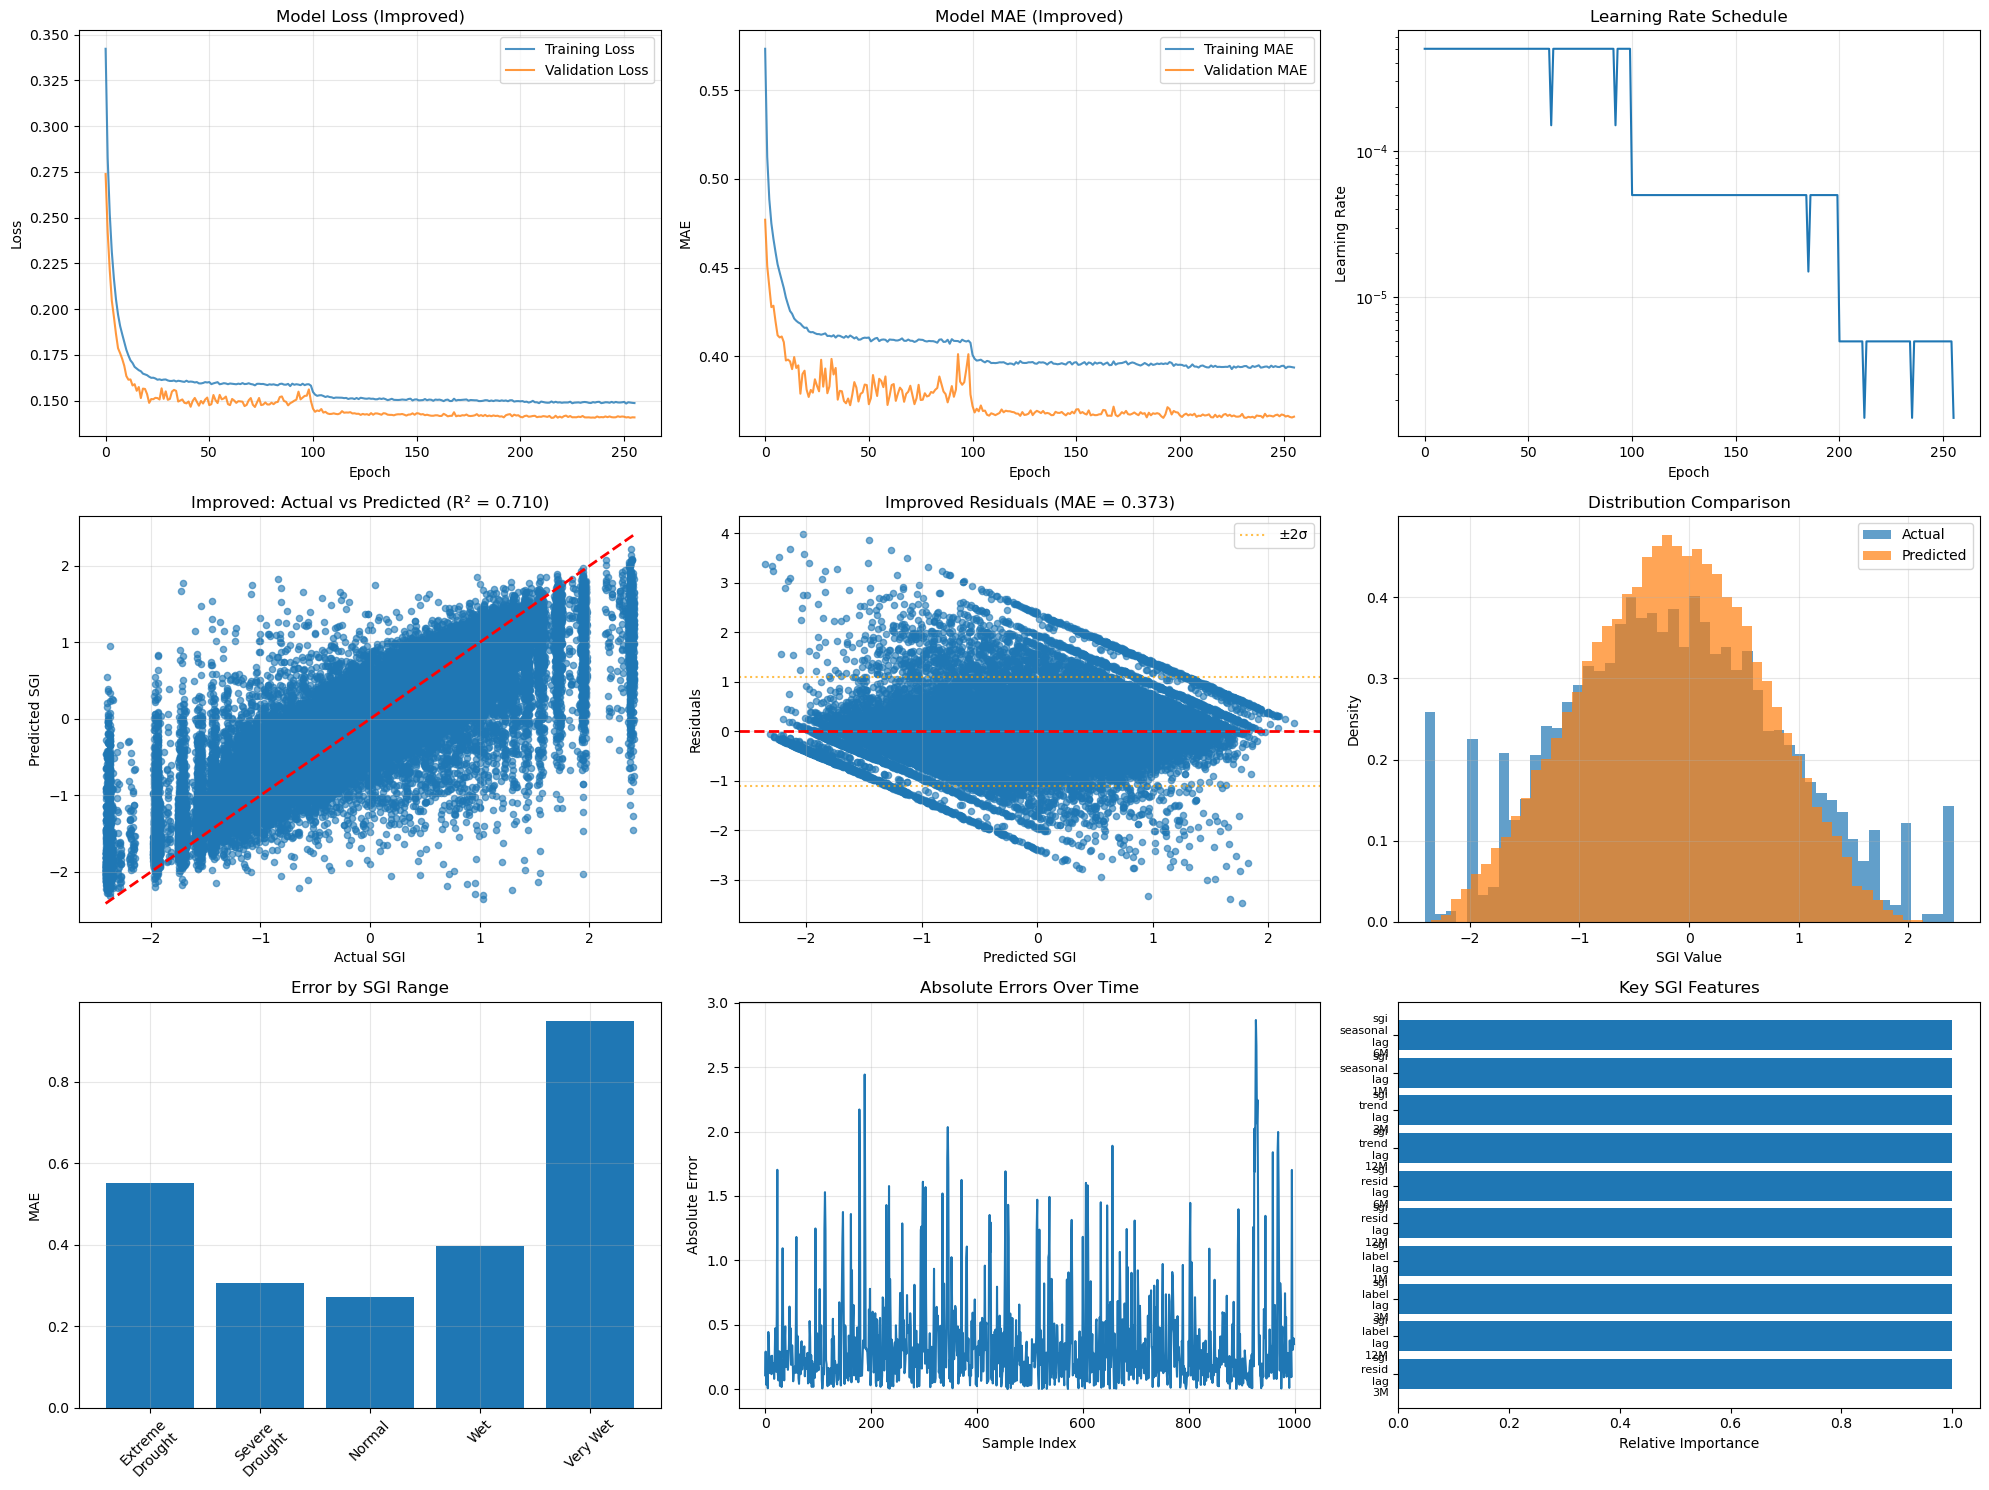

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

class ImprovedTemporalSGIPredictor:
    def __init__(self):
        self.scaler_X = None
        self.scaler_y = None
        self.feature_selector = None
        self.model = None
        self.feature_names = None
        self.best_params = None
        
    def load_and_preprocess_data(self, train_path, test_path):
        """Enhanced data loading with better preprocessing"""
        print("Loading temporal data...")
        
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        
        print(f"Train data shape: {train_df.shape}")
        print(f"Test data shape: {test_df.shape}")
        
        # Convert dates and verify split
        train_df['date'] = pd.to_datetime(train_df['date'])
        test_df['date'] = pd.to_datetime(test_df['date'])
        
        train_max_date = train_df['date'].max()
        test_min_date = test_df['date'].min()
        print(f"Train data: up to {train_max_date}")
        print(f"Test data: from {test_min_date}")
        
        # Remove date column
        train_model = train_df.drop('date', axis=1)
        test_model = test_df.drop('date', axis=1)
        
        target_col = 'sgi_target_label'
        feature_cols = [col for col in train_model.columns if col != target_col]
        
        # Ensure common features
        common_features = list(set(feature_cols) & set(test_model.columns))
        
        X_train = train_model[common_features]
        y_train = train_model[target_col]
        X_test = test_model[common_features]
        y_test = test_model[target_col]
        
        # Remove rows with missing targets
        train_mask = ~y_train.isnull()
        test_mask = ~y_test.isnull()
        
        X_train = X_train[train_mask]
        y_train = y_train[train_mask]
        X_test = X_test[test_mask]
        y_test = y_test[test_mask]
        
        print(f"Target distribution shift:")
        print(f"  Train: mean={y_train.mean():.3f}, std={y_train.std():.3f}")
        print(f"  Test:  mean={y_test.mean():.3f}, std={y_test.std():.3f}")
        
        # Enhanced missing value handling
        print("Handling missing values...")
        
        # Calculate missing percentages
        train_missing_pct = (X_train.isnull().sum() / len(X_train)) * 100
        features_high_missing = train_missing_pct[train_missing_pct > 50].index.tolist()
        
        if features_high_missing:
            print(f"Removing {len(features_high_missing)} features with >50% missing values")
            X_train = X_train.drop(columns=features_high_missing)
            X_test = X_test.drop(columns=features_high_missing)
        
        # Fill remaining missing values with more sophisticated approach
        for col in X_train.columns:
            if X_train[col].dtype in ['float64', 'int64']:
                # Use median for numerical features
                fill_value = X_train[col].median()
            else:
                # Use mode for categorical features
                fill_value = X_train[col].mode().iloc[0] if not X_train[col].mode().empty else 0
            
            X_train[col] = X_train[col].fillna(fill_value)
            X_test[col] = X_test[col].fillna(fill_value)
        
        # Feature engineering: create interaction terms for important SGI lags
        sgi_lag_features = [col for col in X_train.columns if 'sgi_' in col and 'lag' in col]
        if len(sgi_lag_features) >= 2:
            print("Creating SGI interaction features...")
            # Create interaction between 1M and 3M lags
            if 'sgi_label_lag_1M' in X_train.columns and 'sgi_label_lag_3M' in X_train.columns:
                X_train['sgi_1M_3M_interaction'] = X_train['sgi_label_lag_1M'] * X_train['sgi_label_lag_3M']
                X_test['sgi_1M_3M_interaction'] = X_test['sgi_label_lag_1M'] * X_test['sgi_label_lag_3M']
            
            # Create seasonal difference
            if 'sgi_seasonal_lag_1M' in X_train.columns and 'sgi_seasonal_lag_12M' in X_train.columns:
                X_train['sgi_seasonal_diff'] = X_train['sgi_seasonal_lag_1M'] - X_train['sgi_seasonal_lag_12M']
                X_test['sgi_seasonal_diff'] = X_test['sgi_seasonal_lag_1M'] - X_test['sgi_seasonal_lag_12M']
        
        # Remove low variance features
        print("Removing low variance features...")
        selector = VarianceThreshold(threshold=0.01)
        X_train_selected = selector.fit_transform(X_train)
        X_test_selected = selector.transform(X_test)
        
        selected_features = np.array(X_train.columns)[selector.get_support()]
        X_train = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
        X_test = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)
        
        # Feature selection based on correlation with target
        print("Selecting most relevant features...")
        self.feature_selector = SelectKBest(score_func=f_regression, k=min(30, len(selected_features)))
        X_train_final = self.feature_selector.fit_transform(X_train, y_train)
        X_test_final = self.feature_selector.transform(X_test)
        
        final_features = selected_features[self.feature_selector.get_support()]
        X_train = pd.DataFrame(X_train_final, columns=final_features, index=X_train.index)
        X_test = pd.DataFrame(X_test_final, columns=final_features, index=X_test.index)
        
        self.feature_names = list(final_features)
        
        print(f"Final features selected: {len(final_features)}")
        print(f"Final train shape: {X_train.shape}")
        print(f"Final test shape: {X_test.shape}")
        
        return X_train, y_train, X_test, y_test
    
    def create_advanced_model(self, params, input_dim):
        """Create advanced model architecture"""
        model = keras.Sequential()
        
        # Input layer with higher capacity
        model.add(layers.Dense(
            params['n_units_1'], 
            activation=params['activation'],
            input_shape=(input_dim,),
            kernel_regularizer=keras.regularizers.l2(params['l2_reg']),
            kernel_initializer='he_normal'
        ))
        model.add(layers.Dropout(params['dropout_rate']))
        if params['batch_norm']:
            model.add(layers.BatchNormalization())
        
        # Second layer
        model.add(layers.Dense(
            params['n_units_2'], 
            activation=params['activation'],
            kernel_regularizer=keras.regularizers.l2(params['l2_reg']),
            kernel_initializer='he_normal'
        ))
        model.add(layers.Dropout(params['dropout_rate'] * 0.8))
        if params['batch_norm']:
            model.add(layers.BatchNormalization())
        
        # Third layer
        model.add(layers.Dense(
            params['n_units_3'], 
            activation=params['activation'],
            kernel_regularizer=keras.regularizers.l2(params['l2_reg']),
            kernel_initializer='he_normal'
        ))
        model.add(layers.Dropout(params['dropout_rate'] * 0.6))
        
        # Fourth layer (new)
        model.add(layers.Dense(
            params['n_units_4'], 
            activation=params['activation'],
            kernel_regularizer=keras.regularizers.l2(params['l2_reg']),
            kernel_initializer='he_normal'
        ))
        model.add(layers.Dropout(params['dropout_rate'] * 0.4))
        
        # Output layer
        model.add(layers.Dense(1, activation='linear', kernel_initializer='normal'))
        
        # Advanced optimizer
        if params['optimizer'] == 'adamw':
            try:
                optimizer = keras.optimizers.AdamW(
                    learning_rate=params['learning_rate'],
                    weight_decay=params['l2_reg']
                )
            except AttributeError:
                optimizer = keras.optimizers.Adam(learning_rate=params['learning_rate'])
        else:
            optimizer = keras.optimizers.Adam(learning_rate=params['learning_rate'])
        
        # Use Huber loss for robustness
        try:
            #loss_fn = keras.losses.Huber(delta=1.0)
            loss_fn = 'mse'
        except AttributeError:
            loss_fn = 'mse'
        
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['mae']
        )
        
        return model
    
    def train_improved_model(self, X_train, y_train, X_test, y_test):
        """Train with improved parameters and techniques"""
        print("\nTraining improved model...")
        
        # Better hyperparameters based on analysis
        params = {
            'n_units_1': 256,  # Increased capacity
            'n_units_2': 128,
            'n_units_3': 64,
            'n_units_4': 32,   # Additional layer
            'dropout_rate': 0.4,  # Higher dropout for regularization
            'learning_rate': 0.0005,  # Lower learning rate
            'batch_norm': True,
            'activation': 'elu',
            'optimizer': 'adamw',
            'l2_reg': 1e-4,
            'batch_size': 128  # Larger batch size
        }
        
        print(f"Using improved parameters:")
        print(f"  Architecture: {params['n_units_1']}-{params['n_units_2']}-{params['n_units_3']}-{params['n_units_4']}")
        print(f"  Dropout: {params['dropout_rate']}, LR: {params['learning_rate']}")
        
        # Create temporal validation split
        split_idx = int(len(X_train) * 0.85)
        X_train_final = X_train.iloc[:split_idx]
        X_val_final = X_train.iloc[split_idx:]
        y_train_final = y_train.iloc[:split_idx]
        y_val_final = y_train.iloc[split_idx:]
        
        print(f"Temporal split: {len(X_train_final)} train, {len(X_val_final)} val, {len(X_test)} test")
        
        # Advanced scaling with PowerTransformer for target
        self.scaler_X = RobustScaler()
        
        # Try PowerTransformer for target to handle distribution shift
        try:
            self.scaler_y = PowerTransformer(method='yeo-johnson', standardize=True)
            y_train_scaled = self.scaler_y.fit_transform(y_train_final.values.reshape(-1, 1)).flatten()
            y_val_scaled = self.scaler_y.transform(y_val_final.values.reshape(-1, 1)).flatten()
            print("Using PowerTransformer for target scaling")
        except:
            self.scaler_y = RobustScaler()
            y_train_scaled = self.scaler_y.fit_transform(y_train_final.values.reshape(-1, 1)).flatten()
            y_val_scaled = self.scaler_y.transform(y_val_final.values.reshape(-1, 1)).flatten()
            print("Using RobustScaler for target scaling")
        
        X_train_scaled = self.scaler_X.fit_transform(X_train_final)
        X_val_scaled = self.scaler_X.transform(X_val_final)
        X_test_scaled = self.scaler_X.transform(X_test)
        
        # Create model
        self.model = self.create_advanced_model(params, X_train_scaled.shape[1])
        
        print("Advanced model architecture:")
        self.model.summary()
        
        # Enhanced callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=40,  # More patience
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.3,  # More aggressive reduction
                patience=20,
                min_lr=1e-8,
                verbose=1
            ),
            # Cosine annealing for better convergence
            keras.callbacks.LearningRateScheduler(
                lambda epoch: params['learning_rate'] * (0.1 ** (epoch // 100)),
                verbose=0
            )
        ]
        
        # Train with more epochs
        history = self.model.fit(
            X_train_scaled, y_train_scaled,
            validation_data=(X_val_scaled, y_val_scaled),
            epochs=300,  # More epochs
            batch_size=params['batch_size'],
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate on temporal test set
        y_pred_scaled = self.model.predict(X_test_scaled)
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"\n" + "="*60)
        print("IMPROVED TEMPORAL TEST SET PERFORMANCE")
        print("="*60)
        print(f"  MSE: {mse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R²: {r2:.4f}")
        print(f"  RMSE: {np.sqrt(mse):.4f}")
        
        # Additional metrics for different SGI ranges
        self.analyze_performance_by_range(y_test, y_pred)
        
        # Store results
        self.test_results = {
            'y_true': y_test,
            'y_pred': y_pred,
            'history': history,
            'used_params': params
        }
        
        return history
    
    def analyze_performance_by_range(self, y_true, y_pred):
        """Analyze performance across different SGI ranges"""
        print(f"\nPerformance by SGI range:")
        
        ranges = [
            (-float('inf'), -1.5, "Extreme Drought"),
            (-1.5, -1.0, "Severe Drought"),
            (-1.0, -0.5, "Moderate Drought"),
            (-0.5, 0.5, "Normal"),
            (0.5, 1.0, "Wet"),
            (1.0, float('inf'), "Very Wet")
        ]
        
        for low, high, label in ranges:
            mask = (y_true >= low) & (y_true < high)
            if mask.sum() > 0:
                range_mae = mean_absolute_error(y_true[mask], y_pred[mask])
                range_r2 = r2_score(y_true[mask], y_pred[mask])
                print(f"  {label:15s}: MAE={range_mae:.3f}, R²={range_r2:.3f}, n={mask.sum()}")
    
    def plot_enhanced_results(self):
        """Enhanced plotting with more insights"""
        if not hasattr(self, 'test_results'):
            print("No results to plot.")
            return
            
        history = self.test_results['history']
        y_true = self.test_results['y_true']
        y_pred = self.test_results['y_pred']
        
        fig = plt.figure(figsize=(20, 15))
        
        # Training history (2x2 grid for top)
        ax1 = plt.subplot(3, 3, 1)
        ax1.plot(history.history['loss'], label='Training Loss', alpha=0.8)
        ax1.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
        ax1.set_title('Model Loss (Improved)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = plt.subplot(3, 3, 2)
        ax2.plot(history.history['mae'], label='Training MAE', alpha=0.8)
        ax2.plot(history.history['val_mae'], label='Validation MAE', alpha=0.8)
        ax2.set_title('Model MAE (Improved)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Learning rate schedule
        ax3 = plt.subplot(3, 3, 3)
        if 'lr' in history.history:
            ax3.plot(history.history['lr'])
            ax3.set_title('Learning Rate Schedule')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Learning Rate')
            ax3.set_yscale('log')
            ax3.grid(True, alpha=0.3)
        
        # Predictions scatter
        ax4 = plt.subplot(3, 3, 4)
        ax4.scatter(y_true, y_pred, alpha=0.6, s=20)
        ax4.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        ax4.set_xlabel('Actual SGI')
        ax4.set_ylabel('Predicted SGI')
        ax4.set_title(f'Improved: Actual vs Predicted (R² = {r2_score(y_true, y_pred):.3f})')
        ax4.grid(True, alpha=0.3)
        
        # Residuals plot
        ax5 = plt.subplot(3, 3, 5)
        residuals = y_true - y_pred
        ax5.scatter(y_pred, residuals, alpha=0.6, s=20)
        ax5.axhline(y=0, color='r', linestyle='--', linewidth=2)
        
        std_residuals = np.std(residuals)
        ax5.axhline(y=2*std_residuals, color='orange', linestyle=':', alpha=0.7, label='±2σ')
        ax5.axhline(y=-2*std_residuals, color='orange', linestyle=':', alpha=0.7)
        
        ax5.set_xlabel('Predicted SGI')
        ax5.set_ylabel('Residuals')
        ax5.set_title(f'Improved Residuals (MAE = {mean_absolute_error(y_true, y_pred):.3f})')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # Distribution comparison
        ax6 = plt.subplot(3, 3, 6)
        ax6.hist(y_true, bins=50, alpha=0.7, label='Actual', density=True)
        ax6.hist(y_pred, bins=50, alpha=0.7, label='Predicted', density=True)
        ax6.set_xlabel('SGI Value')
        ax6.set_ylabel('Density')
        ax6.set_title('Distribution Comparison')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # Error by SGI range
        ax7 = plt.subplot(3, 3, 7)
        ranges = [(-3, -1.5), (-1.5, -0.5), (-0.5, 0.5), (0.5, 1.5), (1.5, 3)]
        range_labels = ['Extreme\nDrought', 'Severe\nDrought', 'Normal', 'Wet', 'Very Wet']
        range_errors = []
        
        for low, high in ranges:
            mask = (y_true >= low) & (y_true < high)
            if mask.sum() > 0:
                range_errors.append(mean_absolute_error(y_true[mask], y_pred[mask]))
            else:
                range_errors.append(0)
        
        ax7.bar(range_labels, range_errors)
        ax7.set_ylabel('MAE')
        ax7.set_title('Error by SGI Range')
        ax7.tick_params(axis='x', rotation=45)
        ax7.grid(True, alpha=0.3)
        
        # Time series of errors (if we had dates)
        ax8 = plt.subplot(3, 3, 8)
        ax8.plot(np.abs(residuals)[:1000])  # Plot first 1000 absolute errors
        ax8.set_xlabel('Sample Index')
        ax8.set_ylabel('Absolute Error')
        ax8.set_title('Absolute Errors Over Time')
        ax8.grid(True, alpha=0.3)
        
        # Feature importance (top features)
        ax9 = plt.subplot(3, 3, 9)
        if hasattr(self, 'feature_names') and len(self.feature_names) > 0:
            # Simple feature importance based on feature names
            sgi_features = [f for f in self.feature_names if 'sgi' in f.lower()][:10]
            if sgi_features:
                ax9.barh(range(len(sgi_features)), [1]*len(sgi_features))
                ax9.set_yticks(range(len(sgi_features)))
                ax9.set_yticklabels([f.replace('_', '\n') for f in sgi_features], fontsize=8)
                ax9.set_xlabel('Relative Importance')
                ax9.set_title('Key SGI Features')
        
        plt.tight_layout()
        plt.show()

# Usage function
def main_improved():
    """Improved training pipeline"""
    predictor = ImprovedTemporalSGIPredictor()
    
    # Load and preprocess data with improvements
    X_train, y_train, X_test, y_test = predictor.load_and_preprocess_data(
        '../train_data.csv', 
        '../train_data.csv.csv'
    )
    
    # Train improved model
    history = predictor.train_improved_model(X_train, y_train, X_test, y_test)
    
    # Plot enhanced results
    predictor.plot_enhanced_results()
    
    return predictor

if __name__ == "__main__":
    predictor = main_improved()

Starte Skript: SGI-Berechnung, SGI-Dekomposition und erweiterte ML-Pipeline mit Neural Network
Gefundene Zeitreihen mit Kriterien für ML: 264
Ziel-GROW_ID für den Dekompositionsplot: GROW-80939064354
Anzahl eindeutiger GROW_IDs für ML-Datenbasis: 264
Beginne mit SGI-Berechnung, SGI-Dekomposition & Feature-Extraktion für 264 GROW_IDs...
   Verarbeite Gruppe 20/264: GROW-80922120567
   Verarbeite Gruppe 40/264: GROW-80924423213
   Verarbeite Gruppe 60/264: GROW-80927301782
   Verarbeite Gruppe 80/264: GROW-80931816834
   Verarbeite Gruppe 100/264: GROW-80935336548
   Verarbeite Gruppe 120/264: GROW-80937459453

Erstelle Dekompositionsplot für SGI (GROW_ID: GROW-80939064354)


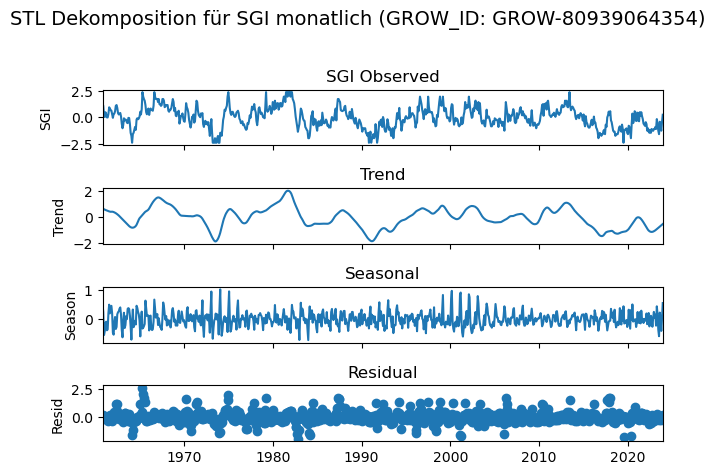

   Verarbeite Gruppe 140/264: GROW-80939756408
   Verarbeite Gruppe 160/264: GROW-80942271186
   Verarbeite Gruppe 180/264: GROW-80945357487
   Verarbeite Gruppe 200/264: GROW-80947532792
   Verarbeite Gruppe 220/264: GROW-80950527383
   Verarbeite Gruppe 240/264: GROW-80952921019
   Verarbeite Gruppe 260/264: GROW-80956930857
SGI-Berechnung, SGI-Dekomposition & dynamische Feature-Extraktion für ML abgeschlossen.
Form des ML-Input-DataFrames vor Feature Engineering: (179988, 17)
Starte erweiterte Machine-Learning-Pipeline mit SGI-Dekompositions-Features...
One-Hot Encoding für Spalte: main_landuse
One-Hot Encoding für Spalte: month_num
Form des ML-DataFrames nach One-Hot Encoding: (179988, 48)
Imputation für 2 statische numerische Features...

DEBUG: Analysiere NaN-Werte vor dem Filtern...
Gesamtanzahl Zeilen vor NaN-Filter: 179988
  sgi_target_6M_future: 1584/179988 NaN-Werte (0.9%)
  sgi_label: 0/179988 NaN-Werte (0.0%)

Anwende flexiblere NaN-Behandlung...
Nach Label-Filter (sgi_tar

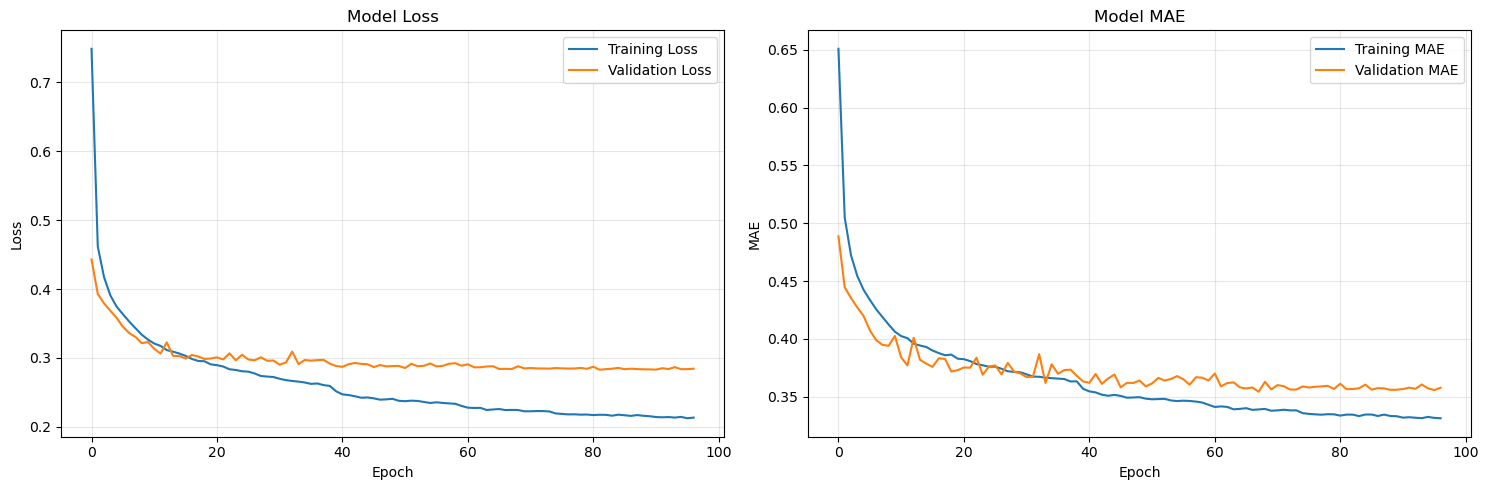


Neural Network Performance auf Testdaten:
R² Score (Vorhersagehorizont 6 Monate): 0.6679
RMSE (Vorhersagehorizont 6 Monate): 0.5589
MAE (Vorhersagehorizont 6 Monate): 0.3884


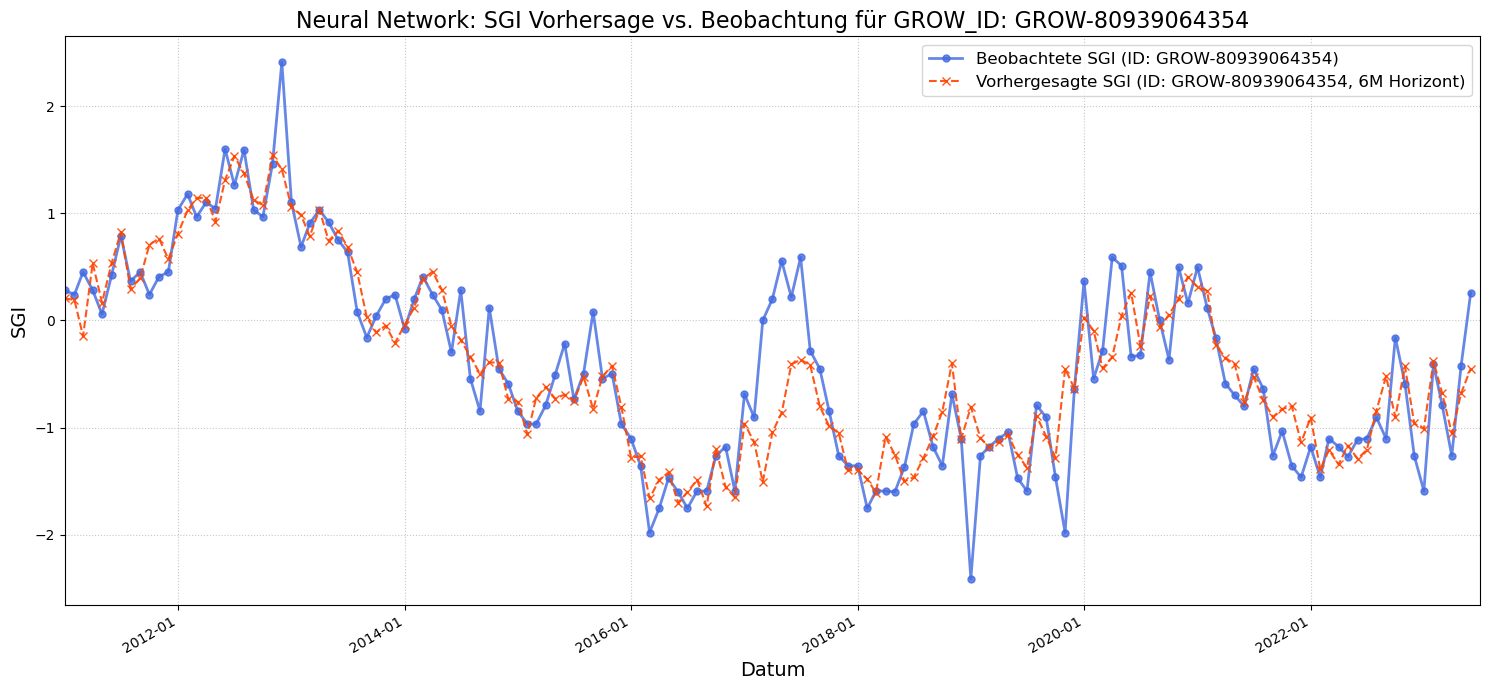

Berechne SHAP Values für Neural Network...
32/32 [==============================] - 0s 4ms/step


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

3125/3125 [==============================] - 5s 2ms/step


<Figure size 1200x700 with 0 Axes>

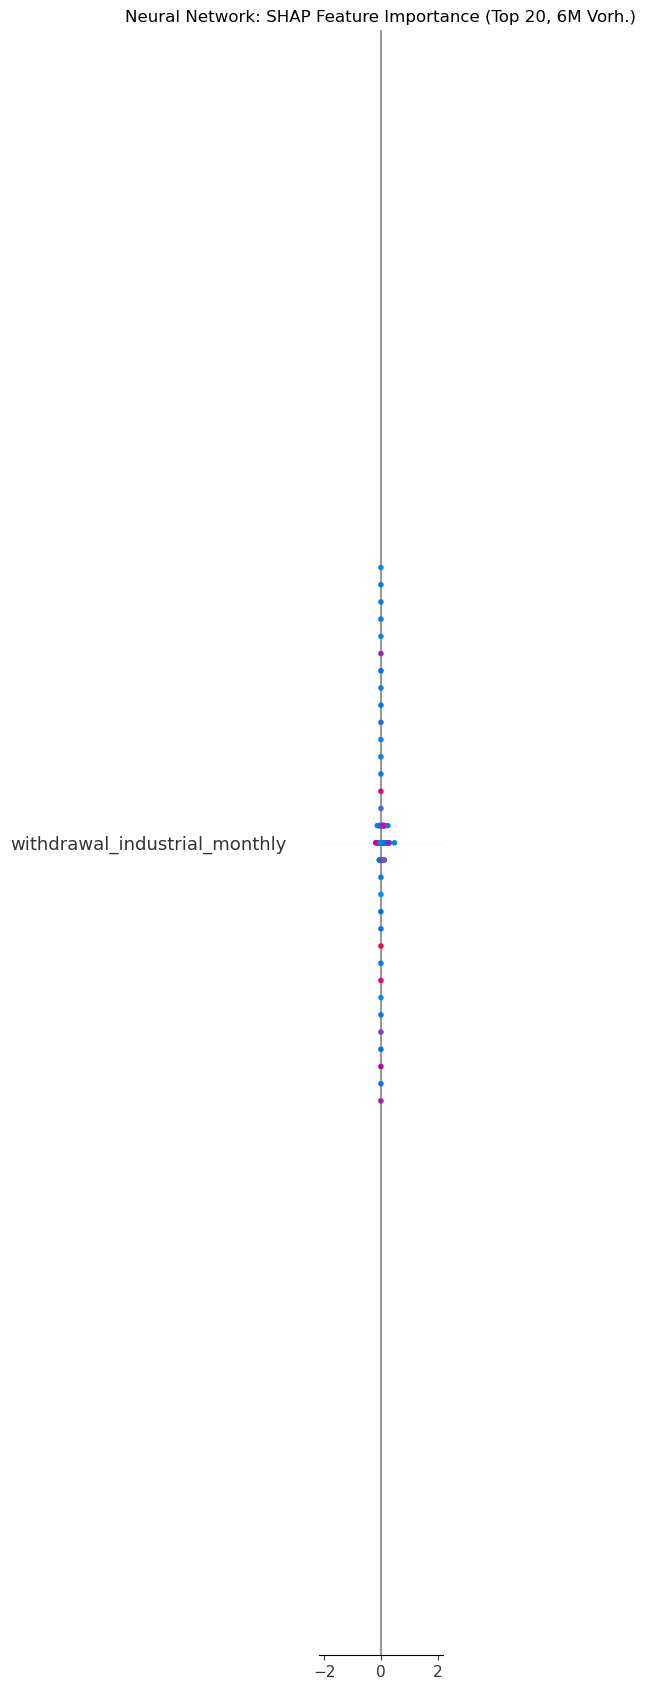

<Figure size 1200x700 with 0 Axes>

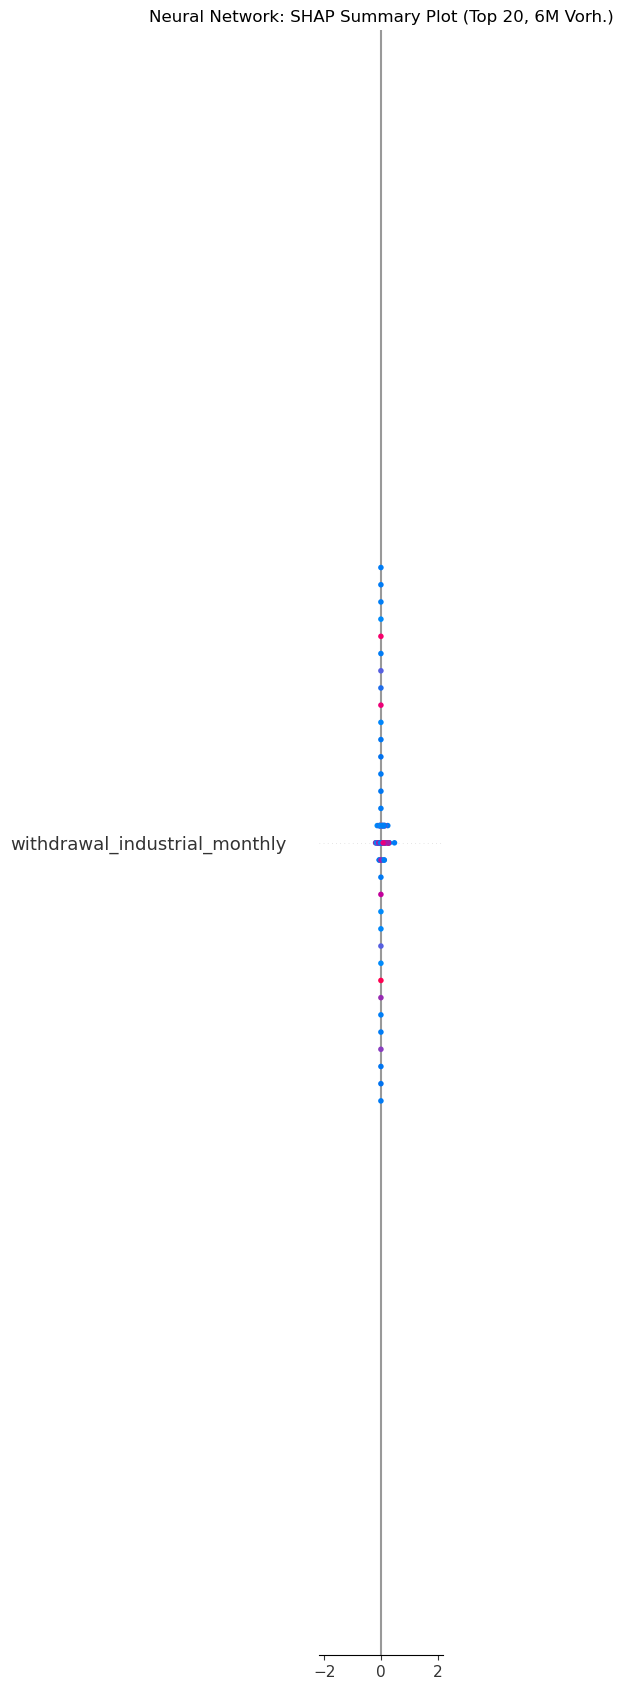

Neural Network Pipeline (SGI-Dekomposition, 6M Vorh.) abgeschlossen.
Speichere Trainings- und Testdaten in CSV-Dateien...


OSError: Cannot save file into a non-existent directory: 'C:\MLmitPython\ML-Python'

In [19]:
# --- TEIL 0: Bibliotheken importieren und Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Für Datumsformatierung
import pastas as ps
import pyarrow.dataset as ds
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import gc # Garbage Collector
from statsmodels.tsa.seasonal import STL # Für Zeitreihen-Dekomposition

# Neue Imports für Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Loglevel für Pastas reduzieren
ps.set_log_level("ERROR")
print("Starte Skript: SGI-Berechnung, SGI-Dekomposition und erweiterte ML-Pipeline mit Neural Network")

# --------------------------------------------------------------------------
# Definition der ursprünglichen Feature-Typen aus den Eingabedateien
# --------------------------------------------------------------------------

# Statische Features aus 'grow_attributes.parquet'
STATIC_CATEGORICAL_FEATURES = [
    "main_landuse"  # Nur main_landuse beibehalten
]

STATIC_NUMERICAL_FEATURES = [
    "ground_elevation_m_asl",   # Höhe über dem Meeresspiegel
    "topographic_slope_degrees",# Topographische Neigung
]

# Dynamische Features aus 'grow_timeseries.parquet'
DYNAMIC_NUMERICAL_FEATURES_RAW = [
    "groundwater_level_m_asl",
    "precipitation_gpcc_mm_year-1",
    "potential_evapotranspiration_era5_mm_year-1",
    "air_temperature_°C",
    "snow_depth_m",
    "ndvi_ratio",
    "lai_low_vegetation_ratio",
    "lai_high_vegetation_ratio",
    "withdrawal_industrial_m3_year-1",
    "withdrawal_domestic_m3_year-1"
]

# Globale Variable für den Plot-Status der Dekomposition
decomposition_plot_done = False
target_grow_id_for_decomposition_plot = None # Wird später gesetzt

# --- TEIL 1: Datenauswahl und SGI-Berechnung für das ML-Label & Feature Collection ---
try:
    attr_df_full = pd.read_parquet("../Daten/grow_attributes.parquet")
except FileNotFoundError:
    print("Fehler: '../Daten/grow_attributes.parquet' nicht gefunden.")
    raise
except Exception as e:
    print(f"Fehler beim Laden von '../Daten/grow_attributes.parquet': {e}")
    raise

# Datentypen in attr_df frühzeitig optimieren
for col in attr_df_full.select_dtypes(include=['float64']).columns:
    attr_df_full[col] = attr_df_full[col].astype(np.float32)
for col in attr_df_full.select_dtypes(include=['int64']).columns:
    if attr_df_full[col].min() >= np.iinfo(np.int32).min and attr_df_full[col].max() <= np.iinfo(np.int32).max:
        attr_df_full[col] = attr_df_full[col].astype(np.int32)

attr_filtered_df = attr_df_full[
    (attr_df_full["country"] == "CZE") &
    (attr_df_full["length_years"] >= 30) &
    (attr_df_full["gap_fraction"] == 0.0) &
    (pd.to_datetime(attr_df_full["ending_date"]) >= pd.Timestamp("2023-12-01"))
]
print(f"Gefundene Zeitreihen mit Kriterien für ML: {len(attr_filtered_df)}")
if attr_filtered_df.empty:
    raise ValueError("Keine passende Zeitreihe für CZ für ML gefunden.")

target_grow_id_for_decomposition_plot = attr_filtered_df.sort_values("length_years", ascending=False).iloc[0]["GROW_ID"]
print(f"Ziel-GROW_ID für den Dekompositionsplot: {target_grow_id_for_decomposition_plot}")

cz_ids_for_ml = attr_filtered_df["GROW_ID"].dropna().unique().tolist()
print(f"Anzahl eindeutiger GROW_IDs für ML-Datenbasis: {len(cz_ids_for_ml)}")

dynamic_feature_columns_to_load = ["GROW_ID", "date"] + DYNAMIC_NUMERICAL_FEATURES_RAW

try:
    timeseries_dataset_raw = ds.dataset("../Daten/grow_timeseries.parquet", format="parquet")
    available_columns_in_parquet = timeseries_dataset_raw.schema.names
    columns_to_actually_load = [col for col in dynamic_feature_columns_to_load if col in available_columns_in_parquet]

    timeseries_table_raw = timeseries_dataset_raw.to_table(
        filter=ds.field("GROW_ID").isin(cz_ids_for_ml),
        columns=columns_to_actually_load
    )
    raw_ts_df_full = timeseries_table_raw.to_pandas(self_destruct=True, split_blocks=True, zero_copy_only=False)
except FileNotFoundError:
    print("Fehler: '../Daten/grow_timeseries.parquet' nicht gefunden.")
    raise
except Exception as e:
    print(f"Fehler beim Laden von Zeitreihen: {e}")
    raise

raw_ts_df_full["date"] = pd.to_datetime(raw_ts_df_full["date"])
if "precipitation_gpcc_mm_year-1" in raw_ts_df_full.columns:
    raw_ts_df_full["precipitation_gpcc_mm_month-1"] = (raw_ts_df_full["precipitation_gpcc_mm_year-1"] / 12).astype(np.float32)
if "potential_evapotranspiration_era5_mm_year-1" in raw_ts_df_full.columns:
    raw_ts_df_full["potential_evapotranspiration_era5_mm_month-1"] = (raw_ts_df_full["potential_evapotranspiration_era5_mm_year-1"] / 12).astype(np.float32)

cols_to_convert_float32 = [
    "groundwater_level_m_asl", "air_temperature_°C", "snow_depth_m", "ndvi_ratio",
    "lai_low_vegetation_ratio", "lai_high_vegetation_ratio",
    "withdrawal_industrial_m3_year-1", "withdrawal_domestic_m3_year-1"
]
for col in cols_to_convert_float32:
    if col in raw_ts_df_full.columns:
        raw_ts_df_full[col] = raw_ts_df_full[col].astype(np.float32)

grouped_ts_data = raw_ts_df_full.set_index('date').groupby('GROW_ID')
del raw_ts_df_full
gc.collect()

all_ml_data_list = []
print(f"Beginne mit SGI-Berechnung, SGI-Dekomposition & Feature-Extraktion für {len(cz_ids_for_ml)} GROW_IDs...")

def process_grow_id_data(grow_id_data, current_grow_id):
    global decomposition_plot_done, target_grow_id_for_decomposition_plot

    gwl_series_raw = grow_id_data["groundwater_level_m_asl"].dropna()
    if gwl_series_raw.empty: return None
    gwl_series_monthly = gwl_series_raw.resample('MS').mean().astype(np.float32)

    if len(gwl_series_monthly.dropna()) < 120: # Mindestens 10 Jahre an monatlichen Daten
        return None

    try:
        sgi_observed_monthly = ps.stats.sgi(gwl_series_monthly)
        if sgi_observed_monthly.empty or sgi_observed_monthly.isnull().all():
            return None
    except Exception as e:
        return None

    sgi_trend = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)
    sgi_seasonal = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)
    sgi_resid = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)

    sgi_for_stl = sgi_observed_monthly.dropna()
    if len(sgi_for_stl) >= 25: # STL benötigt mindestens 2 Periodenzyklen + 1
        try:
            stl = STL(sgi_for_stl, period=12, robust=True)
            res_stl = stl.fit()

            sgi_trend = res_stl.trend.reindex(sgi_observed_monthly.index).astype(np.float32)
            sgi_seasonal = res_stl.seasonal.reindex(sgi_observed_monthly.index).astype(np.float32)
            sgi_resid = res_stl.resid.reindex(sgi_observed_monthly.index).astype(np.float32)

            if current_grow_id == target_grow_id_for_decomposition_plot and not decomposition_plot_done:
                print(f"\nErstelle Dekompositionsplot für SGI (GROW_ID: {current_grow_id})")
                try:
                    fig_stl = res_stl.plot()
                    fig_stl.suptitle(f"STL Dekomposition für SGI monatlich (GROW_ID: {current_grow_id})", fontsize=14)

                    if len(fig_stl.axes) > 0:
                        fig_stl.axes[0].set_title("SGI Observed")
                        fig_stl.axes[0].set_ylabel("SGI")
                    if len(fig_stl.axes) > 1: fig_stl.axes[1].set_title("Trend")
                    if len(fig_stl.axes) > 2: fig_stl.axes[2].set_title("Seasonal")
                    if len(fig_stl.axes) > 3: fig_stl.axes[3].set_title("Residual")

                    plt.tight_layout(rect=[0, 0, 1, 0.96])
                    plt.show()
                    decomposition_plot_done = True
                except Exception as plot_e:
                    print(f"   Fehler beim Erstellen des STL-Plots für {current_grow_id}: {plot_e}")
        except Exception as e_stl:
                print(f"   Fehler bei STL-Dekomposition für GROW_ID {current_grow_id}: {e_stl}.")

    monthly_features_dict = {
        'sgi_label': sgi_observed_monthly,
        'sgi_trend': sgi_trend,
        'sgi_seasonal': sgi_seasonal,
        'sgi_resid': sgi_resid
    }

    dynamic_to_monthly_map = {
        "precipitation_gpcc_mm_month-1": "precipitation_monthly",
        "potential_evapotranspiration_era5_mm_month-1": "evapotranspiration_monthly",
        "air_temperature_°C": "air_temperature_monthly",
        "snow_depth_m": "snow_depth_monthly",
        "ndvi_ratio": "ndvi_monthly",
        "lai_low_vegetation_ratio": "lai_low_veg_monthly",
        "lai_high_vegetation_ratio": "lai_high_veg_monthly"
    }
    for col_name_orig, col_name_target in dynamic_to_monthly_map.items():
        if col_name_orig in grow_id_data.columns:
            feat_series = grow_id_data[col_name_orig].dropna().resample('MS').mean()
            monthly_features_dict[col_name_target] = feat_series.reindex(sgi_observed_monthly.index).astype(np.float32)
        else:
            monthly_features_dict[col_name_target] = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)

    yearly_to_monthly_ffill_map = {
        "withdrawal_industrial_m3_year-1": "withdrawal_industrial_monthly",
        "withdrawal_domestic_m3_year-1": "withdrawal_domestic_monthly"
    }
    for col_name_orig, col_name_target in yearly_to_monthly_ffill_map.items():
        if col_name_orig in grow_id_data.columns:
            feat_series_yearly = grow_id_data[col_name_orig].dropna()
            if not feat_series_yearly.index.is_unique:
                feat_series_yearly = feat_series_yearly[~feat_series_yearly.index.duplicated(keep='first')]
            feat_series_monthly_ffill = feat_series_yearly.resample('MS').ffill()
            monthly_features_dict[col_name_target] = feat_series_monthly_ffill.reindex(sgi_observed_monthly.index).astype(np.float32)
        else:
            monthly_features_dict[col_name_target] = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)

    combined_monthly_df = pd.DataFrame(monthly_features_dict)
    combined_monthly_df.dropna(subset=['sgi_label'], inplace=True)
    return combined_monthly_df

processed_groups = []
for i, (grow_id, group_data) in enumerate(grouped_ts_data):
    if (i + 1) % 20 == 0:
        print(f"   Verarbeite Gruppe {i+1}/{len(grouped_ts_data)}: {grow_id}")
    processed_df = process_grow_id_data(group_data, grow_id)
    if processed_df is not None and not processed_df.empty:
        processed_df['GROW_ID'] = grow_id
        processed_groups.append(processed_df)
del grouped_ts_data
gc.collect()

print("SGI-Berechnung, SGI-Dekomposition & dynamische Feature-Extraktion für ML abgeschlossen.")
if not processed_groups:
    raise ValueError("Keine Daten für ML-Modell nach Verarbeitung.")

df_ml_input_dynamic = pd.concat(processed_groups)
del processed_groups
gc.collect()

static_features_to_select = ["GROW_ID"] + STATIC_NUMERICAL_FEATURES + STATIC_CATEGORICAL_FEATURES
static_features_to_select = [col for col in static_features_to_select if col in attr_df_full.columns]

attr_df_ml_static = attr_df_full[attr_df_full['GROW_ID'].isin(cz_ids_for_ml)][static_features_to_select].copy()
attr_df_ml_static.drop_duplicates(subset=['GROW_ID'], inplace=True, keep='first')
for col in attr_df_ml_static.select_dtypes(include=['float64']).columns:
    attr_df_ml_static[col] = attr_df_ml_static[col].astype(np.float32)

df_ml_input_dynamic.reset_index(inplace=True)
df_ml_input_with_static = pd.merge(df_ml_input_dynamic, attr_df_ml_static, on="GROW_ID", how="left")
df_ml_input_with_static.set_index('date', inplace=True)
df_ml_input = df_ml_input_with_static

del df_ml_input_dynamic, attr_df_ml_static, attr_df_full, attr_filtered_df
gc.collect()

print(f"Form des ML-Input-DataFrames vor Feature Engineering: {df_ml_input.shape}")
if df_ml_input.empty:
    raise ValueError("ML-Input-DataFrame ist leer.")

# --- TEIL 2: Machine-Learning-Pipeline ---
print("Starte erweiterte Machine-Learning-Pipeline mit SGI-Dekompositions-Features...")
df_ml_processed = df_ml_input.copy()
gc.collect()

for lag_col_base in ['sgi_label', 'sgi_trend', 'sgi_seasonal', 'sgi_resid']:
    if lag_col_base not in df_ml_processed.columns:
        print(f"Warnung: Spalte {lag_col_base} nicht in df_ml_processed gefunden. Überspringe Lag-Erstellung dafür.")
        continue
    for lag_val in [1, 3, 6, 12]:
        target_col = f'{lag_col_base}_lag_{lag_val}M'
        df_ml_processed[target_col] = df_ml_processed.groupby('GROW_ID')[lag_col_base].shift(lag_val).astype(np.float32)

df_ml_processed['month_num'] = df_ml_processed.index.month.astype(np.int8)
df_ml_processed['year'] = df_ml_processed.index.year.astype(np.int32)

VORHERSAGE_HORIZONT_MONATE = 6 # Beibehaltung des Horizonts
df_ml_processed[f'sgi_target_{VORHERSAGE_HORIZONT_MONATE}M_future'] = df_ml_processed.groupby('GROW_ID')['sgi_label'].shift(-VORHERSAGE_HORIZONT_MONATE).astype(np.float32)

categorical_cols_to_encode = STATIC_CATEGORICAL_FEATURES + ['month_num']
categorical_cols_to_encode = [col for col in categorical_cols_to_encode if col in df_ml_processed.columns or col == 'month_num']

for col in categorical_cols_to_encode:
    if col in df_ml_processed.columns:
        df_ml_processed[col] = df_ml_processed[col].fillna('Missing').astype(str)

dummy_encoded_cols_list = []
for col_to_encode in categorical_cols_to_encode:
    if col_to_encode in df_ml_processed.columns:
        print(f"One-Hot Encoding für Spalte: {col_to_encode}")
        dummies = pd.get_dummies(df_ml_processed[col_to_encode], prefix=col_to_encode, dummy_na=False, dtype=np.int8)
        df_ml_processed = pd.concat([df_ml_processed, dummies], axis=1)
        df_ml_processed.drop(columns=[col_to_encode], inplace=True)
        dummy_encoded_cols_list.extend(dummies.columns.tolist())
print(f"Form des ML-DataFrames nach One-Hot Encoding: {df_ml_processed.shape}")

# Imputation für statische numerische Features
numerical_static_cols_for_imputation = [col for col in STATIC_NUMERICAL_FEATURES if col in df_ml_processed.columns]
if numerical_static_cols_for_imputation:
    print(f"Imputation für {len(numerical_static_cols_for_imputation)} statische numerische Features...")
    for col in numerical_static_cols_for_imputation:
        if df_ml_processed[col].isna().any():
            median_val = df_ml_processed[col].median()
            if pd.isna(median_val):  # Falls alle Werte NaN sind
                median_val = 0.0
            df_ml_processed[col] = df_ml_processed[col].fillna(median_val).astype(np.float32)

base_features_ml = [
    "precipitation_monthly", "evapotranspiration_monthly", "air_temperature_monthly",
    "snow_depth_monthly", "ndvi_monthly", "lai_low_veg_monthly", "lai_high_veg_monthly",
    "withdrawal_industrial_monthly", "withdrawal_domestic_monthly"
]
base_features_ml = [col for col in base_features_ml if col in df_ml_processed.columns]

lag_features_sgi_label_ml = [f'sgi_label_lag_{lag}M' for lag in [1, 3, 6, 12] if f'sgi_label_lag_{lag}M' in df_ml_processed.columns]
lag_features_sgi_trend_ml = [f'sgi_trend_lag_{lag}M' for lag in [1, 3, 6, 12] if f'sgi_trend_lag_{lag}M' in df_ml_processed.columns]
lag_features_sgi_seasonal_ml = [f'sgi_seasonal_lag_{lag}M' for lag in [1, 3, 6, 12] if f'sgi_seasonal_lag_{lag}M' in df_ml_processed.columns]
lag_features_sgi_resid_ml = [f'sgi_resid_lag_{lag}M' for lag in [1, 3, 6, 12] if f'sgi_resid_lag_{lag}M' in df_ml_processed.columns]

numerical_static_features_ml = numerical_static_cols_for_imputation

features_columns_ml = list(set(
    base_features_ml +
    lag_features_sgi_label_ml +
    lag_features_sgi_trend_ml +
    lag_features_sgi_seasonal_ml +
    lag_features_sgi_resid_ml +
    numerical_static_features_ml +
    dummy_encoded_cols_list
))
features_columns_ml = [col for col in features_columns_ml if col in df_ml_processed.columns]

label_column_ml = f'sgi_target_{VORHERSAGE_HORIZONT_MONATE}M_future'

df_ml_input_for_plot = df_ml_input.copy()
del df_ml_input
gc.collect()

# DEBUG: Prüfe NaN-Werte vor dem Filtern
print(f"\nDEBUG: Analysiere NaN-Werte vor dem Filtern...")
print(f"Gesamtanzahl Zeilen vor NaN-Filter: {len(df_ml_processed)}")

# Prüfe kritische Spalten auf NaN-Werte
critical_columns = [label_column_ml, 'sgi_label']
critical_columns = [col for col in critical_columns if col in df_ml_processed.columns]

for col in critical_columns:
    nan_count = df_ml_processed[col].isna().sum()
    total_count = len(df_ml_processed)
    print(f"  {col}: {nan_count}/{total_count} NaN-Werte ({nan_count/total_count*100:.1f}%)")

# FLEXIBLERE NaN-Behandlung
print(f"\nAnwende flexiblere NaN-Behandlung...")

# Schritt 1: Entferne Zeilen ohne Label (das ist kritisch)
if label_column_ml in df_ml_processed.columns:
    before_label_filter = len(df_ml_processed)
    df_ml_processed = df_ml_processed.dropna(subset=[label_column_ml])
    after_label_filter = len(df_ml_processed)
    print(f"Nach Label-Filter ({label_column_ml}): {after_label_filter} Zeilen (entfernt: {before_label_filter - after_label_filter})")

# Schritt 2: Entferne Zeilen ohne sgi_label (auch kritisch)
if 'sgi_label' in df_ml_processed.columns:
    before_sgi_filter = len(df_ml_processed)
    df_ml_processed = df_ml_processed.dropna(subset=['sgi_label'])
    after_sgi_filter = len(df_ml_processed)
    print(f"Nach SGI-Label-Filter: {after_sgi_filter} Zeilen (entfernt: {before_sgi_filter - after_sgi_filter})")

# Schritt 3: Prüfe wichtige Lag-Features, aber weniger strikt
important_lag_features = ['sgi_label_lag_1M']
important_lag_features = [col for col in important_lag_features if col in df_ml_processed.columns]

if important_lag_features:
    before_lag_filter = len(df_ml_processed)
    df_ml_processed = df_ml_processed.dropna(subset=important_lag_features)
    after_lag_filter = len(df_ml_processed)
    print(f"Nach wichtigen Lag-Features-Filter: {after_lag_filter} Zeilen (entfernt: {before_lag_filter - after_lag_filter})")

# Schritt 4: Sichere Imputation für dynamische Features
dynamic_features_for_imputation = [
    'precipitation_monthly', 'evapotranspiration_monthly', 'air_temperature_monthly',
    'snow_depth_monthly', 'ndvi_monthly', 'lai_low_veg_monthly', 'lai_high_veg_monthly',
    'withdrawal_industrial_monthly', 'withdrawal_domestic_monthly'
]
dynamic_features_for_imputation = [col for col in dynamic_features_for_imputation if col in df_ml_processed.columns]

if dynamic_features_for_imputation:
    print(f"Sichere Imputation für {len(dynamic_features_for_imputation)} dynamische Features...")
    for col in dynamic_features_for_imputation:
        if df_ml_processed[col].isna().any():
            # Prüfe ob die Spalte komplett NaN ist
            if df_ml_processed[col].isna().all():
                print(f"  Warnung: Spalte {col} ist komplett NaN, setze auf 0.0")
                df_ml_processed[col] = 0.0
            else:
                # Verwende Median-Imputation
                median_val = df_ml_processed[col].median()
                if pd.isna(median_val):
                    median_val = 0.0
                df_ml_processed[col] = df_ml_processed[col].fillna(median_val)
            
            # Stelle sicher, dass der Datentyp korrekt ist
            df_ml_processed[col] = df_ml_processed[col].astype(np.float32)

# Schritt 5: Sichere Imputation für Lag-Features
lag_features_for_imputation = [col for col in features_columns_ml 
                              if '_lag_' in col and col not in important_lag_features and col in df_ml_processed.columns]

if lag_features_for_imputation:
    print(f"Sichere Imputation für {len(lag_features_for_imputation)} Lag-Features...")
    for col in lag_features_for_imputation:
        if df_ml_processed[col].isna().any():
            # Versuche Forward-Fill innerhalb jeder GROW_ID
            df_ml_processed[col] = df_ml_processed.groupby('GROW_ID')[col].fillna(method='ffill')
            
            # Falls immer noch NaN-Werte vorhanden, verwende Median oder 0
            if df_ml_processed[col].isna().any():
                if df_ml_processed[col].isna().all():
                    print(f"  Warnung: Lag-Feature {col} ist komplett NaN, setze auf 0.0")
                    df_ml_processed[col] = 0.0
                else:
                    median_val = df_ml_processed[col].median()
                    if pd.isna(median_val):
                        median_val = 0.0
                    df_ml_processed[col] = df_ml_processed[col].fillna(median_val)
            
            # Stelle sicher, dass der Datentyp korrekt ist
            df_ml_processed[col] = df_ml_processed[col].astype(np.float32)

print(f"Form des ML-DataFrames nach sicherer NaN-Behandlung: {df_ml_processed.shape}")

# Finale Prüfung auf verbleibende NaN-Werte
all_feature_cols = features_columns_ml + [label_column_ml]
all_feature_cols = [col for col in all_feature_cols if col in df_ml_processed.columns]

remaining_nan_cols = []
for col in all_feature_cols:
    if df_ml_processed[col].isna().any():
        remaining_nan_cols.append(col)

if remaining_nan_cols:
    print(f"Warnung: Verbleibende NaN-Werte in {len(remaining_nan_cols)} Spalten:")
    for col in remaining_nan_cols:
        nan_count = df_ml_processed[col].isna().sum()
        total_count = len(df_ml_processed)
        print(f"  {col}: {nan_count}/{total_count} NaN-Werte ({nan_count/total_count*100:.1f}%)")
    
    # Finale Bereinigung: Entferne Zeilen mit verbleibenden NaN-Werten
    print("Entferne Zeilen mit verbleibenden NaN-Werten...")
    before_final_clean = len(df_ml_processed)
    df_ml_processed = df_ml_processed.dropna(subset=all_feature_cols)
    after_final_clean = len(df_ml_processed)
    print(f"Nach finaler NaN-Bereinigung: {after_final_clean} Zeilen (entfernt: {before_final_clean - after_final_clean})")

if df_ml_processed.empty:
    print("FEHLER: DataFrame ist nach NaN-Behandlung leer!")
    print("Mögliche Ursachen:")
    print("1. Alle Labels sind NaN (Problem bei der SGI-Berechnung oder Lag-Erstellung)")
    print("2. Problem bei der Feature-Erstellung")
    print("3. Daten enthalten keine gültigen Zeitreihen")
    
    # Debug-Information
    print(f"\nDEBUG: Verfügbare Spalten in df_ml_processed:")
    if hasattr(df_ml_processed, 'columns'):
        print(df_ml_processed.columns.tolist())
    
    # Prüfe ursprüngliche Daten
    print(f"\nDEBUG: Ursprüngliche Eingabedaten:")
    print(f"df_ml_input_for_plot shape: {df_ml_input_for_plot.shape if 'df_ml_input_for_plot' in locals() else 'Nicht verfügbar'}")
    
    raise ValueError("Keine Daten nach Feature Engineering und sicherer NaN-Bereinigung übrig.")
else:
    print(f"✓ Erfolgreich {df_ml_processed.shape[0]} Zeilen für ML-Training vorbereitet.")
    
    # Zeige finale Statistiken
    print(f"\nFinale Datenstatistiken:")
    print(f"  Anzahl Features: {len(features_columns_ml)}")
    print(f"  Anzahl GROW_IDs: {df_ml_processed['GROW_ID'].nunique()}")
    print(f"  Zeitraum: {df_ml_processed.index.min()} bis {df_ml_processed.index.max()}")

# Daten für das Modell vorbereiten (X und y)
X_all_features_raw = df_ml_processed[features_columns_ml].copy()
y_all_labels = df_ml_processed[label_column_ml].copy()
X_meta_for_split = df_ml_processed[['GROW_ID', 'year']].copy()

del df_ml_processed
gc.collect()

# --- TRAIN/TEST SPLIT (ZEITBASIERT - ERFOLGT VOR DER SKALIERUNG) ---
temp_year_series = X_meta_for_split['year']
unique_years_ml = np.sort(temp_year_series.unique())

X_train_raw, X_test_raw = None, None
y_train, y_test = None, None
X_meta_train_ids_info = None
X_meta_test_ids = None

if len(unique_years_ml) <= 1:
    print("Warnung: Weniger als 2 Jahre Daten für zeitlichen Split. Nutze zufälligen Split (sortiert) als Fallback.")
    indices = np.arange(len(X_all_features_raw))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, shuffle=False, random_state=42)

    X_train_raw = X_all_features_raw.iloc[train_indices]
    X_test_raw = X_all_features_raw.iloc[test_indices]
    y_train = y_all_labels.iloc[train_indices]
    y_test = y_all_labels.iloc[test_indices]

    X_meta_train_ids_info = X_meta_for_split.iloc[train_indices][['GROW_ID']]
    X_meta_test_ids = X_meta_for_split.iloc[test_indices][['GROW_ID']]
else:
    split_year_index_ml = int(len(unique_years_ml) * 0.8)
    if split_year_index_ml >= len(unique_years_ml): split_year_index_ml = len(unique_years_ml) - 1
    split_year_ml = unique_years_ml[split_year_index_ml if split_year_index_ml > 0 else 0]
    print(f"Split-Jahr für Training/Test: Daten vor {split_year_ml} für Training, ab {split_year_ml} für Test.")

    train_mask_ml = temp_year_series < split_year_ml
    test_mask_ml = temp_year_series >= split_year_ml

    X_train_raw = X_all_features_raw[train_mask_ml]
    X_test_raw = X_all_features_raw[test_mask_ml]
    y_train = y_all_labels[train_mask_ml]
    y_test = y_all_labels[test_mask_ml]

    X_meta_train_ids_info = X_meta_for_split[train_mask_ml][['GROW_ID']]
    X_meta_test_ids = X_meta_for_split[test_mask_ml][['GROW_ID']]

del X_all_features_raw, y_all_labels, temp_year_series, X_meta_for_split
gc.collect()

print(f"Größe Roh-Trainingsdaten (X_train_raw): {X_train_raw.shape}")
print(f"Größe Roh-Testdaten (X_test_raw): {X_test_raw.shape}")

if X_train_raw.empty:
    raise ValueError("Trainingsdatensatz (X_train_raw) nach Split leer.")

# --- SKALIERUNG NUMERISCHER FEATURES (NACH DEM SPLIT) ---
numerical_cols_to_scale = [
    col for col in X_train_raw.columns
    if col not in dummy_encoded_cols_list and \
       X_train_raw[col].dtype in [np.float32, np.float64, np.int32, np.int64, np.int8]
]

X_train = pd.DataFrame(index=X_train_raw.index)
X_test = pd.DataFrame(index=X_test_raw.index) if not X_test_raw.empty else pd.DataFrame(columns=X_train_raw.columns)

if numerical_cols_to_scale:
    scaler = StandardScaler()
    print(f"Skaliere {len(numerical_cols_to_scale)} numerische Features...")

    scaler.fit(X_train_raw[numerical_cols_to_scale])

    scaled_train_values = scaler.transform(X_train_raw[numerical_cols_to_scale])
    X_train_scaled_numerical_df = pd.DataFrame(scaled_train_values, columns=numerical_cols_to_scale, index=X_train_raw.index)
    for col in X_train_scaled_numerical_df.columns:
        X_train[col] = X_train_scaled_numerical_df[col]

    if not X_test_raw.empty:
        numerical_cols_to_scale_in_test = [col for col in numerical_cols_to_scale if col in X_test_raw.columns]
        if numerical_cols_to_scale_in_test:
            scaled_test_values = scaler.transform(X_test_raw[numerical_cols_to_scale_in_test])
            X_test_scaled_numerical_df = pd.DataFrame(scaled_test_values, columns=numerical_cols_to_scale_in_test, index=X_test_raw.index)
            for col in X_test_scaled_numerical_df.columns:
                X_test[col] = X_test_scaled_numerical_df[col]
        else:
            print("Warnung: Keine übereinstimmenden numerischen Spalten im Testset zum Skalieren gefunden.")
else:
    print("Keine numerischen Features zum Skalieren im Trainingsset identifiziert.")

# Füge die (nicht-skalierten) Dummy-Variablen hinzu
dummy_cols_in_train = [col for col in dummy_encoded_cols_list if col in X_train_raw.columns]
for col in dummy_cols_in_train:
    X_train[col] = X_train_raw[col]

if not X_test_raw.empty:
    dummy_cols_in_test = [col for col in dummy_encoded_cols_list if col in X_test_raw.columns]
    for col in dummy_cols_in_test:
        X_test[col] = X_test_raw[col]

# Stelle die ursprüngliche Spaltenreihenfolge sicher
final_train_cols = [col for col in features_columns_ml if col in X_train.columns]
X_train = X_train[final_train_cols]

if not X_test.empty:
    final_test_cols = [col for col in features_columns_ml if col in X_test.columns]
    X_test = X_test[final_test_cols]
else:
    X_test = pd.DataFrame(columns=final_train_cols)

del X_train_raw
if 'X_test_raw' in locals() and X_test_raw is not None: del X_test_raw
if 'X_train_scaled_numerical_df' in locals(): del X_train_scaled_numerical_df
if 'X_test_scaled_numerical_df' in locals(): del X_test_scaled_numerical_df
gc.collect()

print(f"Größe finale Trainingsdaten (X_train): {X_train.shape}")
print(f"Größe finale Testdaten (X_test): {X_test.shape}")

if X_train.empty:
    raise ValueError("Trainingsdatensatz (X_train) nach Skalierung leer.")

if X_meta_train_ids_info is not None:
    unique_grow_ids_in_train = X_meta_train_ids_info['GROW_ID'].nunique()
    print(f"Modell wird mit {X_train.shape[0]} Datenpunkten von {unique_grow_ids_in_train} eindeutigen Zeitreihen (GROW_IDs) trainiert.")
    del X_meta_train_ids_info
    gc.collect()

# --- NEURAL NETWORK MODELL TRAINING UND EVALUATION ---
print("Starte Neural Network Training...")

# Konvertiere zu numpy arrays für TensorFlow
X_train_np = X_train.values.astype(np.float32)
y_train_np = y_train.values.astype(np.float32)

if not X_test.empty and not y_test.empty:
    X_test_np = X_test.values.astype(np.float32)
    y_test_np = y_test.values.astype(np.float32)
else:
    X_test_np = None
    y_test_np = None

# Neural Network Architektur für 120k Trainingsdaten
def create_neural_network(input_dim):
    model = keras.Sequential([
        # Input Layer
        layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden Layers
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        
        # Output Layer
        layers.Dense(1, activation='linear')
    ])
    
    # Optimizer mit guten Hyperparametern für diese Datengröße
    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

# Modell erstellen
input_dim = X_train_np.shape[1]
nn_model = create_neural_network(input_dim)

print(f"Neural Network Architektur für {input_dim} Input Features:")
nn_model.summary()

# Callbacks für Training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    )
]

# Validation Split für Training
validation_split = 0.15

# Training
print("Starte Neural Network Training...")
history = nn_model.fit(
    X_train_np, y_train_np,
    epochs=100,
    batch_size=256,  # Gute Batch-Größe für 120k Samples
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

# Training History Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluation auf Testdaten
if X_test_np is not None and y_test_np is not None:
    y_pred_nn = nn_model.predict(X_test_np, batch_size=256, verbose=0)
    y_pred_nn_series = pd.Series(y_pred_nn.flatten(), index=y_test.index, name="SGI_Predicted")

    r2_nn = r2_score(y_test_np, y_pred_nn)
    rmse_nn = np.sqrt(mean_squared_error(y_test_np, y_pred_nn))
    mae_nn = np.mean(np.abs(y_test_np - y_pred_nn.flatten()))
    
    print(f"\nNeural Network Performance auf Testdaten:")
    print(f"R² Score (Vorhersagehorizont {VORHERSAGE_HORIZONT_MONATE} Monate): {r2_nn:.4f}")
    print(f"RMSE (Vorhersagehorizont {VORHERSAGE_HORIZONT_MONATE} Monate): {rmse_nn:.4f}")
    print(f"MAE (Vorhersagehorizont {VORHERSAGE_HORIZONT_MONATE} Monate): {mae_nn:.4f}")

    # --- Plot: Vorhersage für eine spezifische GROW_ID ---
    if target_grow_id_for_decomposition_plot and X_meta_test_ids is not None:
        mask_target_id_test = X_meta_test_ids['GROW_ID'] == target_grow_id_for_decomposition_plot
        y_test_target_id = y_test[mask_target_id_test]
        y_pred_target_id = y_pred_nn_series[mask_target_id_test]

        if not y_test_target_id.empty:
            fig, ax = plt.subplots(figsize=(15, 7))
            ax.plot(y_test_target_id.index, y_test_target_id.values,
                    label=f'Beobachtete SGI (ID: {target_grow_id_for_decomposition_plot})',
                    marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=5, alpha=0.8)
            ax.plot(y_pred_target_id.index, y_pred_target_id.values,
                    label=f'Vorhergesagte SGI (ID: {target_grow_id_for_decomposition_plot}, {VORHERSAGE_HORIZONT_MONATE}M Horizont)',
                    marker='x', linestyle='--', color='orangered', linewidth=1.5, markersize=6, alpha=0.9)

            start_plot_date = pd.Timestamp("2008-01-01")
            min_date_in_plot = y_test_target_id.index.min() if not y_test_target_id.empty else pd.NaT
            max_date_in_plot = y_test_target_id.index.max() if not y_test_target_id.empty else pd.NaT

            plot_start_lim = max(min_date_in_plot, start_plot_date) if pd.notnull(min_date_in_plot) else start_plot_date
            plot_end_lim = max_date_in_plot + pd.Timedelta(days=30) if pd.notnull(max_date_in_plot) else pd.Timestamp.now()

            ax.set_xlim(left=plot_start_lim, right=plot_end_lim)
            ax.set_title(f'Neural Network: SGI Vorhersage vs. Beobachtung für GROW_ID: {target_grow_id_for_decomposition_plot}', fontsize=16)
            ax.set_xlabel('Datum', fontsize=14)
            ax.set_ylabel('SGI', fontsize=14)
            ax.legend(fontsize=12)
            ax.grid(True, linestyle=':', alpha=0.7)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            fig.autofmt_xdate()
            plt.tight_layout()
            plt.show()
        else:
            print(f"Keine Testdaten für GROW_ID {target_grow_id_for_decomposition_plot} nach Filterung gefunden.")

    # --- SHAP Value Berechnung für Neural Network ---
    try:
        if not X_test.empty and not X_test.dropna(axis=1, how='all').empty:
            print("Berechne SHAP Values für Neural Network...")
            
            # Für Neural Networks verwenden wir KernelExplainer mit einer Stichprobe der Trainingsdaten
            background_sample_size = min(1000, len(X_train_np))
            background_indices = np.random.choice(len(X_train_np), background_sample_size, replace=False)
            background_data = X_train_np[background_indices]
            
            # SHAP Explainer für Neural Network
            explainer_nn = shap.KernelExplainer(nn_model.predict, background_data)
            
            # Berechne SHAP values für eine Stichprobe der Testdaten (wegen Rechenzeit)
            test_sample_size = min(100, len(X_test_np))
            test_indices = np.random.choice(len(X_test_np), test_sample_size, replace=False)
            test_sample = X_test_np[test_indices]
            
            shap_values_nn = explainer_nn.shap_values(test_sample, nsamples=100)
            
            # SHAP Plots
            max_display_shap = min(20, len(X_test.columns))
            
            plt.figure(figsize=(12, int(max(5, 0.2 * max_display_shap)) + 2))
            shap.summary_plot(shap_values_nn, test_sample, 
                            feature_names=X_test.columns, 
                            plot_type="bar", show=False, max_display=max_display_shap)
            plt.title(f"Neural Network: SHAP Feature Importance (Top {max_display_shap}, {VORHERSAGE_HORIZONT_MONATE}M Vorh.)")
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(12, int(max(5, 0.2 * max_display_shap)) + 2))
            shap.summary_plot(shap_values_nn, test_sample, 
                            feature_names=X_test.columns, 
                            show=False, max_display=max_display_shap)
            plt.title(f"Neural Network: SHAP Summary Plot (Top {max_display_shap}, {VORHERSAGE_HORIZONT_MONATE}M Vorh.)")
            plt.tight_layout()
            plt.show()
            
        else:
            print("X_test ist leer oder enthält keine validen Daten für SHAP-Analyse.")
    except Exception as e:
        print(f"Fehler bei SHAP-Berechnung/Darstellung: {e}")
        print("   -> SHAP-Berechnung für Neural Networks kann sehr zeitaufwändig sein.")

# Cleanup
if 'df_ml_input_for_plot' in locals():
    del df_ml_input_for_plot
    gc.collect()

print(f"Neural Network Pipeline (SGI-Dekomposition, {VORHERSAGE_HORIZONT_MONATE}M Vorh.) abgeschlossen.")

# --- Speichern von Train- und Testdaten in CSV ---
print("Speichere Trainings- und Testdaten in CSV-Dateien...")

# Speichern von X_train und y_train
train_df_to_save = X_train.copy()
train_df_to_save['sgi_target_label'] = y_train
train_df_to_save.to_csv("C:/MLmitPython/ML-Python/train_data.csv", index=True)
print(f"Trainingsdaten gespeichert: train_data.csv mit Shape {train_df_to_save.shape}")

# Speichern von X_test und y_test
if not X_test.empty and not y_test.empty:
    test_df_to_save = X_test.copy()
    test_df_to_save['sgi_target_label'] = y_test
    test_df_to_save.to_csv("C:/MLmitPython/ML-Python/test_data.csv", index=True)
    print(f"Testdaten gespeichert: test_data.csv mit Shape {test_df_to_save.shape}")
else:
    print("Testdaten sind leer, daher keine test_data.csv Datei erstellt.")

# Speichere das trainierte Modell
nn_model.save("C:/MLmitPython/ML-Python/neural_network_model.h5")
print("Neural Network Modell gespeichert: neural_network_model.h5")

print("Speichern der Daten und des Modells abgeschlossen.")